In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import pickle
import obonet
from tqdm.auto import tqdm

In [2]:
import sys
def print_size(data):
    print(f'{sys.getsizeof(data) / (1024 * 1024):.2f} MB')

In [3]:
def pad_with_random_terms(terms, max_terms, all_terms_array, existing_terms_set=None):
    """Optimized padding with random GO terms using rejection sampling."""
    if len(terms) >= max_terms:
        return terms[:max_terms]
    
    # Calculate how many more terms we need
    num_needed = max_terms - len(terms)
    
    # Use pre-computed set if available, otherwise create it
    if existing_terms_set is None:
        existing_terms_set = set(terms)
    
    # For small num_needed relative to available terms, use rejection sampling
    # This avoids creating the full boolean mask
    if num_needed < len(all_terms_array) * 0.1:  # If we need < 10% of total terms
        random_terms = []
        max_attempts = num_needed * 10  # Prevent infinite loop
        attempts = 0
        
        while len(random_terms) < num_needed and attempts < max_attempts:
            # Sample with replacement first (fast)
            batch_size = min(num_needed * 2, 1000)  # Sample in batches
            candidates = np.random.choice(all_terms_array, size=batch_size, replace=True)
            
            # Filter out existing terms
            for candidate in candidates:
                if candidate not in existing_terms_set:
                    random_terms.append(candidate)
                    existing_terms_set.add(candidate)
                    if len(random_terms) >= num_needed:
                        break
            
            attempts += batch_size
        
        # If rejection sampling didn't get enough, fall back to full filtering
        if len(random_terms) < num_needed:
            available_mask = np.isin(all_terms_array, list(existing_terms_set), invert=True)
            available_terms = all_terms_array[available_mask]
            remaining_needed = num_needed - len(random_terms)
            
            if len(available_terms) >= remaining_needed:
                additional = np.random.choice(available_terms, size=remaining_needed, replace=False).tolist()
            else:
                additional = np.random.choice(available_terms, size=remaining_needed, replace=True).tolist()
            
            random_terms.extend(additional)
    else:
        # For large num_needed, use vectorized filtering (more efficient for bulk)
        available_mask = np.isin(all_terms_array, list(existing_terms_set), invert=True)
        available_terms = all_terms_array[available_mask]
        
        # Randomly sample
        if len(available_terms) >= num_needed:
            random_terms = np.random.choice(available_terms, size=num_needed, replace=False).tolist()
        else:
            # If not enough unique terms, sample with replacement
            random_terms = np.random.choice(available_terms, size=num_needed, replace=True).tolist()
    
    return terms + random_terms[:num_needed]

def load_data(data_paths, max_terms=256, aspect=None):
    
    seq_2_terms_df = data_paths['seq_2_terms_df']
    train_terms_df = data_paths['train_terms_df']
    features_embeds_path = data_paths['features_embeds_path']
    features_ids_path = data_paths['features_ids_path']

    go_embeds_paths = data_paths['go_embeds_paths']

    seq_2_terms = pd.read_parquet(seq_2_terms_df, engine='fastparquet')
    train_terms = pd.read_csv(train_terms_df, sep='\t')

    term_to_aspect = train_terms.groupby('term')['aspect'].first().to_dict()
        
    with open(go_embeds_paths, 'rb') as f:
        data = pickle.load(f)
        embeddings_dict = data['embeddings']
        go_ids = data['go_ids']

    # Filter to keep only terms from a specific aspect if aspect is provided
    print('filtering by aspect:', aspect)
    if aspect is not None:
        seq_2_terms['terms_predicted'] = seq_2_terms['terms_predicted'].apply(
            lambda terms: [t for t in terms if term_to_aspect.get(t) == aspect]
        )
        seq_2_terms['terms_true'] = seq_2_terms['terms_true'].apply(
            lambda terms: [t for t in terms if term_to_aspect.get(t) == aspect]
        )
        # Remove rows where terms_predicted or terms_true is now empty
        seq_2_terms = seq_2_terms[seq_2_terms['terms_predicted'].apply(len) > 0]
        seq_2_terms = seq_2_terms[seq_2_terms['terms_true'].apply(len) > 0]

        # Pad terms with random terms from the same aspect
        print(f"Padding terms_predicted with random terms from aspect {aspect}...")
        # Get all terms from this aspect that have embeddings
        aspect_terms = [term for term, asp in term_to_aspect.items() if asp == aspect and term in embeddings_dict]
        all_aspect_terms = np.array(aspect_terms)
        
        tqdm.pandas(desc=f"Padding with random {aspect} terms")
        seq_2_terms['terms_predicted'] = seq_2_terms['terms_predicted'].progress_apply(
            lambda terms: pad_with_random_terms(terms, max_terms, all_aspect_terms)
        )
        
        # Verify padding
        term_lengths_after = seq_2_terms['terms_predicted'].apply(len)
        print(f"After padding - Min: {term_lengths_after.min()}, Max: {term_lengths_after.max()}, Mean: {term_lengths_after.mean():.2f}")

    
    print("loading features embeddings and ids")
    features_embeds = np.load(features_embeds_path, allow_pickle=True)
    features_ids = np.load(features_ids_path, allow_pickle=True)
    
    print("creating features embeddings dict")
    features_embeds_dict = {feat_id: embed for feat_id, embed in zip(features_ids, features_embeds)}

    term_lengths = seq_2_terms['terms_predicted'].apply(len)

    print("filtering sequences by term lengths")
   #currently only using sequences with 256 terms, need to change later 
    # seq_2_terms = seq_2_terms[term_lengths == max_terms]

    train_ids =  pd.DataFrame(features_ids, columns=['qseqid'])
    seq_2_terms = seq_2_terms.merge(train_ids, on='qseqid', how='inner')    

    out = {'seq_2_terms': seq_2_terms,
           'train_terms': train_terms,
           'features_embeds': features_embeds_dict,
           'go_embeds': embeddings_dict,
           }
    
    return out

data_paths = {
    'seq_2_terms_df':       '/mnt/d/ML/Kaggle/CAFA6-new/seq_2_terms.parquet',
    'train_terms_df':       '/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_terms.tsv',
    "features_embeds_path": "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/archive/protein_embeddings.npy",
    "features_ids_path":    "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/archive/protein_ids.npy",
    'go_embeds_paths':      '/mnt/d/ML/Kaggle/CAFA6-new/uniprot/go_embeddings.pkl'
}

data = load_data(data_paths, max_terms=64, aspect='F')
data['seq_2_terms'].shape

KeyboardInterrupt: 

## Data loading 

In [3]:
def pad_terms_with_neighbors(terms, go_graph, go_embeds, max_terms=256):
    """
    Pad a list of GO terms with neighboring terms from the GO graph.
    
    Args:
        terms: List of GO term IDs
        go_graph: networkx graph of GO ontology
        go_embeds: Dictionary of GO embeddings (to check if term has embedding)
        max_terms: Maximum number of terms to return
    
    Returns:
        List of GO terms padded to max_terms
    """
    padded_terms = list(terms)
    
    if len(padded_terms) >= max_terms:
        return padded_terms[:max_terms]
    
    # Use a set for faster lookup
    terms_set = set(padded_terms)
    
    # Collect neighbors from existing terms
    candidates = set()
    for term in padded_terms:
        if term in go_graph:
            # Get parents (is_a relationships)
            if 'is_a' in go_graph.nodes[term]:
                parents = go_graph.nodes[term].get('is_a', [])
                if isinstance(parents, str):
                    parents = [parents]
                candidates.update(parents)
            
            # Get successors (children) and predecessors (parents)
            candidates.update(go_graph.successors(term))
            candidates.update(go_graph.predecessors(term))
    
    # Remove terms already in the list
    candidates = candidates - terms_set
    
    # Filter candidates to only those with embeddings
    candidates = [c for c in candidates if c in go_embeds]
    
    # Add candidates until we reach max_terms
    for candidate in candidates:
        if len(padded_terms) >= max_terms:
            break
        padded_terms.append(candidate)
        terms_set.add(candidate)
    
    # If still not enough, try neighbors of neighbors
    if len(padded_terms) < max_terms:
        second_level_candidates = set()
        for term in candidates[:100]:  # Limit to avoid too much computation
            if term in go_graph:
                if 'is_a' in go_graph.nodes[term]:
                    parents = go_graph.nodes[term].get('is_a', [])
                    if isinstance(parents, str):
                        parents = [parents]
                    second_level_candidates.update(parents)
                second_level_candidates.update(go_graph.successors(term))
                second_level_candidates.update(go_graph.predecessors(term))
        
        second_level_candidates = second_level_candidates - terms_set
        second_level_candidates = [c for c in second_level_candidates if c in go_embeds]
        
        for candidate in second_level_candidates:
            if len(padded_terms) >= max_terms:
                break
            padded_terms.append(candidate)
    
    return padded_terms

def build_neighbor_cache(go_graph, go_embeds):
    """Pre-compute neighbors for all GO terms to avoid repeated graph queries."""
    print("Building neighbor cache for all GO terms...")
    go_embeds_set = set(go_embeds.keys())
    cache = {}
    
    for term in tqdm(go_embeds_set, desc="Caching neighbors"):
        if term not in go_graph:
            cache[term] = set()
            continue
            
        neighbors = set()
        # Get is_a parents
        parents = go_graph.nodes[term].get('is_a', [])
        if isinstance(parents, str):
            neighbors.add(parents)
        else:
            neighbors.update(parents)
        # Get successors and predecessors
        neighbors.update(go_graph.successors(term))
        neighbors.update(go_graph.predecessors(term))
        
        # Only keep neighbors that have embeddings
        cache[term] = neighbors & go_embeds_set
    
    print(f"Neighbor cache built for {len(cache)} terms")
    return cache

def pad_terms_with_random_walk(terms, neighbor_cache, max_terms=256, seed=None):
    """
    Fast random walk padding using pre-computed neighbor cache.
    
    Args:
        terms: List of GO term IDs
        neighbor_cache: Pre-computed dictionary of term -> neighbors
        max_terms: Maximum number of terms to return
        seed: Random seed for reproducibility
    
    Returns:
        List of GO terms padded to max_terms
    """
    if seed is not None:
        rng = np.random.RandomState(seed)
    else:
        rng = np.random.RandomState()
    
    if len(terms) >= max_terms:
        return list(terms)[:max_terms]
    
    padded_terms = list(terms)
    terms_set = set(padded_terms)
    
    # First level: Collect neighbors from original terms
    candidates = set()
    for term in padded_terms:
        neighbors = neighbor_cache.get(term, set())
        valid_neighbors = neighbors - terms_set
        if valid_neighbors:
            # Sample 30% of neighbors for speed
            n_sample = max(1, len(valid_neighbors) // 3)
            if n_sample < len(valid_neighbors):
                sampled = set(rng.choice(list(valid_neighbors), size=n_sample, replace=False))
                candidates.update(sampled)
            else:
                candidates.update(valid_neighbors)
    
    # Add first-level candidates
    candidates = list(candidates)
    rng.shuffle(candidates)
    num_needed = max_terms - len(padded_terms)
    num_to_add = min(num_needed, len(candidates))
    padded_terms.extend(candidates[:num_to_add])
    terms_set.update(candidates[:num_to_add])
    
    # Second level if still needed
    if len(padded_terms) < max_terms:
        num_needed = max_terms - len(padded_terms)
        # Expand only first 20 candidates
        second_level = set()
        for term in candidates[:min(20, len(candidates))]:
            if len(second_level) >= num_needed * 2:
                break
            neighbors = neighbor_cache.get(term, set())
            valid_neighbors = neighbors - terms_set
            if valid_neighbors:
                # Sample 20% at second level
                n_sample = max(1, len(valid_neighbors) // 5)
                if n_sample < len(valid_neighbors):
                    sampled = set(rng.choice(list(valid_neighbors), size=n_sample, replace=False))
                    second_level.update(sampled)
                else:
                    second_level.update(valid_neighbors)
        
        second_level = list(second_level)
        rng.shuffle(second_level)
        padded_terms.extend(second_level[:num_needed])
    
    return padded_terms

def pad_dataframe_terms(seq_2_terms_df, go_graph, go_embeds, max_terms=256, use_random_walk=False, seed=None, neighbor_cache=None):
    """
    Pad the terms_predicted column in the dataframe in-place using GO graph neighbors.
    
    Args:
        seq_2_terms_df: DataFrame with 'terms_predicted' column
        go_graph: networkx graph of GO ontology
        go_embeds: Dictionary of GO embeddings
        max_terms: Maximum number of terms per row
        use_random_walk: If True, use random walk padding instead of deterministic
        seed: Random seed for random walk (only used if use_random_walk=True)
        neighbor_cache: Pre-computed neighbor cache (will be built if None and use_random_walk=True)
    """
    padding_method = "random walk" if use_random_walk else "deterministic neighbors"
    print(f"Padding terms_predicted with GO graph {padding_method}...")
    
    if use_random_walk:
        # Build neighbor cache if not provided
        if neighbor_cache is None:
            neighbor_cache = build_neighbor_cache(go_graph, go_embeds)
        
        # Use tqdm progress bar for apply operation
        tqdm.pandas(desc=f"Padding with {padding_method}")
        seq_2_terms_df['terms_predicted'] = seq_2_terms_df['terms_predicted'].progress_apply(
            lambda terms: pad_terms_with_random_walk(terms, neighbor_cache, max_terms, seed)
        )
    else:
        tqdm.pandas(desc=f"Padding with {padding_method}")
        seq_2_terms_df['terms_predicted'] = seq_2_terms_df['terms_predicted'].progress_apply(
            lambda terms: pad_terms_with_neighbors(terms, go_graph, go_embeds, max_terms)
        )
    
    print(f"Padding complete. Average terms per row: {seq_2_terms_df['terms_predicted'].apply(len).mean():.2f}")
    return seq_2_terms_df

def pad_with_random_terms(terms, max_terms, all_terms_array, existing_terms_set=None):
    """Optimized padding with random GO terms using rejection sampling."""
    if len(terms) >= max_terms:
        return terms[:max_terms]
    
    # Calculate how many more terms we need
    num_needed = max_terms - len(terms)
    
    # Use pre-computed set if available, otherwise create it
    if existing_terms_set is None:
        existing_terms_set = set(terms)
    
    # For small num_needed relative to available terms, use rejection sampling
    # This avoids creating the full boolean mask
    if num_needed < len(all_terms_array) * 0.1:  # If we need < 10% of total terms
        random_terms = []
        max_attempts = num_needed * 10  # Prevent infinite loop
        attempts = 0
        
        while len(random_terms) < num_needed and attempts < max_attempts:
            # Sample with replacement first (fast)
            batch_size = min(num_needed * 2, 1000)  # Sample in batches
            candidates = np.random.choice(all_terms_array, size=batch_size, replace=True)
            
            # Filter out existing terms
            for candidate in candidates:
                if candidate not in existing_terms_set:
                    random_terms.append(candidate)
                    existing_terms_set.add(candidate)
                    if len(random_terms) >= num_needed:
                        break
            
            attempts += batch_size
        
        # If rejection sampling didn't get enough, fall back to full filtering
        if len(random_terms) < num_needed:
            available_mask = np.isin(all_terms_array, list(existing_terms_set), invert=True)
            available_terms = all_terms_array[available_mask]
            remaining_needed = num_needed - len(random_terms)
            
            if len(available_terms) >= remaining_needed:
                additional = np.random.choice(available_terms, size=remaining_needed, replace=False).tolist()
            else:
                additional = np.random.choice(available_terms, size=remaining_needed, replace=True).tolist()
            
            random_terms.extend(additional)
    else:
        # For large num_needed, use vectorized filtering (more efficient for bulk)
        available_mask = np.isin(all_terms_array, list(existing_terms_set), invert=True)
        available_terms = all_terms_array[available_mask]
        
        # Randomly sample
        if len(available_terms) >= num_needed:
            random_terms = np.random.choice(available_terms, size=num_needed, replace=False).tolist()
        else:
            # If not enough unique terms, sample with replacement
            random_terms = np.random.choice(available_terms, size=num_needed, replace=True).tolist()
    
    return terms + random_terms[:num_needed]
    

def prepare_data(data_paths, max_terms=256, aspect=None, oversample_dict=None):
    """
    Prepare data with optional oversampling using different random walk seeds.
    
    Args:
        data_paths: Dictionary of file paths
        max_terms: Maximum number of terms per sequence
        aspect: Filter by specific GO aspect (C, F, P) or None for all
        oversample_dict: Dictionary mapping protein_id (qseqid) to sampling factor.
                        Each protein will be sampled 'factor' times with different random walk seeds.
                        Example: {'A0A023FBW4': 3, 'P12345': 2} will create 3 copies of the first
                        protein and 2 copies of the second, each with different padding.
    
    Returns:
        Dictionary containing seq_2_terms, train_terms, features_embeds, go_embeds, go_graph
    """
    
    knn_terms_df = data_paths['knn_terms_df']
    train_terms_df = data_paths['train_terms_df']
    features_embeds_path = data_paths['features_embeds_path']
    features_ids_path = data_paths['features_ids_path']

    go_embeds_paths = data_paths['go_embeds_paths']

    seq_2_terms = pd.read_parquet(knn_terms_df, engine='fastparquet')
    train_terms = pd.read_csv(train_terms_df, sep='\t')

    term_to_aspect = train_terms.groupby('term')['aspect'].first().to_dict()

    go_graph = obonet.read_obo(data_paths['go_obo_path'])
        
    with open(go_embeds_paths, 'rb') as f:
        data = pickle.load(f)
        embeddings_dict = data['embeddings']
        go_ids = data['go_ids']

    # Filter to keep only terms from a specific aspect if aspect is provided
    if aspect is not None:
        seq_2_terms['terms_predicted'] = seq_2_terms['terms_predicted'].apply(
            lambda terms: [t for t in terms if term_to_aspect.get(t) == aspect]
        )
        seq_2_terms['terms_true'] = seq_2_terms['terms_true'].apply(
            lambda terms: [t for t in terms if term_to_aspect.get(t) == aspect]
        )
        # Remove rows where terms_predicted or terms_true is now empty
        seq_2_terms = seq_2_terms[seq_2_terms['terms_predicted'].apply(len) > 0]
        seq_2_terms = seq_2_terms[seq_2_terms['terms_true'].apply(len) > 0]


    # features_embeds = np.load(features_embeds_path, allow_pickle=True)
    # # features_ids = np.load(features_ids_path, allow_pickle=True)

    # features_embeds_dict = {feat_id: embed for feat_id, embed in zip(features_ids, features_embeds)}

    # Store original predicted terms before padding (needed for oversampling)
    seq_2_terms['original_predicted'] = seq_2_terms['terms_predicted'].copy()
    
    # Build neighbor cache once if using random walk
    neighbor_cache = build_neighbor_cache(go_graph, embeddings_dict)
    
    # Apply oversampling if requested
    if oversample_dict is not None and len(oversample_dict) > 0:
        print(f"Applying oversampling to {len(oversample_dict)} proteins...")
        
        oversampled_rows = []
        proteins_to_oversample = set(oversample_dict.keys())
        
        # Separate proteins to oversample from the rest
        oversample_mask = seq_2_terms['qseqid'].isin(proteins_to_oversample)
        proteins_to_sample = seq_2_terms[oversample_mask].copy()
        proteins_not_sampled = seq_2_terms[~oversample_mask].copy()
        
        # Pad non-oversampled proteins with default seed
        print(f"Padding {len(proteins_not_sampled)} non-oversampled proteins (seed=42)...")
        tqdm.pandas(desc="Padding non-oversampled")
        proteins_not_sampled['terms_predicted'] = proteins_not_sampled['original_predicted'].progress_apply(
            lambda terms: pad_terms_with_random_walk(terms, neighbor_cache, max_terms, seed=42)
        )
        
        # Process each oversampled protein
        print(f"Padding and oversampling {len(proteins_to_sample)} proteins...")
        for idx, row in tqdm(proteins_to_sample.iterrows(), total=len(proteins_to_sample), desc="Oversampling proteins"):
            qseqid = row['qseqid']
            factor = oversample_dict.get(qseqid, 1)
            
            # Create 'factor' copies with different seeds
            for copy_idx in range(factor):
                seed = 42 + copy_idx * 1000  # Use different seeds for each copy
                new_row = row.copy()
                
                # Apply random walk with unique seed
                padded = pad_terms_with_random_walk(new_row['original_predicted'], neighbor_cache, max_terms, seed=seed)
                new_row['terms_predicted'] = padded
                new_row['oversample_idx'] = copy_idx  # Track which copy this is
                new_row['oversample_seed'] = seed
                
                oversampled_rows.append(new_row)
        
        # Combine non-oversampled and oversampled proteins
        if oversampled_rows:
            oversampled_df = pd.DataFrame(oversampled_rows)
            seq_2_terms = pd.concat([proteins_not_sampled, oversampled_df], ignore_index=True)
        else:
            seq_2_terms = proteins_not_sampled
        
        print(f"After oversampling: {len(seq_2_terms)} total samples (from {len(proteins_not_sampled) + len(proteins_to_sample)} original)")
    else:
        # No oversampling, just apply random walk padding with default seed
        seq_2_terms = pad_dataframe_terms(seq_2_terms, go_graph, embeddings_dict, max_terms=max_terms, 
                                         use_random_walk=True, seed=42, neighbor_cache=neighbor_cache)
    
    # Pad remaining sequences that still don't have max_terms with random GO terms
    term_lengths = seq_2_terms['terms_predicted'].apply(len)
    all_go_terms = np.array(list(embeddings_dict.keys()))  # Convert to numpy array once
    
    print(f"Padding remaining sequences with random GO terms...")
    tqdm.pandas(desc="Random term padding")
    seq_2_terms['terms_predicted'] = seq_2_terms['terms_predicted'].progress_apply(
        lambda terms: pad_with_random_terms(terms, max_terms, all_go_terms)
    )
    
    # Verify all sequences now have max_terms
    term_lengths_after = seq_2_terms['terms_predicted'].apply(len)
    print(f"After random padding - Min: {term_lengths_after.min()}, Max: {term_lengths_after.max()}, Mean: {term_lengths_after.mean():.2f}")

    # Drop the temporary column
    seq_2_terms = seq_2_terms.drop(columns=['original_predicted'], errors='ignore')
    
    # train_ids =  pd.DataFrame(features_ids, columns=['qseqid'])
    # seq_2_terms = seq_2_terms.merge(train_ids, on='qseqid', how='inner')    

    out = {'seq_2_terms': seq_2_terms,
           'train_terms': train_terms,
           'go_embeds': embeddings_dict,
           'go_graph': go_graph
           }      
    return out

In [4]:
#read sampling dict
sampling_dict = pickle.load(open('/mnt/d/ML/Kaggle/CAFA6-new/sampling_dict.pkl', 'rb'))

In [5]:
data_paths = {
    'knn_terms_df':         '/mnt/d/ML/Kaggle/CAFA6-new/uniprot/diamond_knn_predictions.parquet',
    'train_terms_df':       '/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_terms.tsv',
    'go_obo_path':          '/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/go-basic.obo',
    "features_embeds_path": "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/archive/protein_embeddings.npy",
    "features_ids_path":    "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/archive/protein_ids.npy",
    'go_embeds_paths':      '/mnt/d/ML/Kaggle/CAFA6-new/uniprot/go_embeddings.pkl'
}

In [6]:
aspect = None
data = prepare_data(data_paths, max_terms=256, aspect=aspect) #, oversample_dict=sampling_dict)


Building neighbor cache for all GO terms...


Caching neighbors:   0%|          | 0/40122 [00:00<?, ?it/s]

Neighbor cache built for 40122 terms
Padding terms_predicted with GO graph random walk...


Padding with random walk:   0%|          | 0/82201 [00:00<?, ?it/s]

Padding complete. Average terms per row: 201.82
Padding remaining sequences with random GO terms...


Random term padding:   0%|          | 0/82201 [00:00<?, ?it/s]

After random padding - Min: 256, Max: 256, Mean: 256.00


In [5]:
# C max term 42
# F max terms 34
# P max terms 188  128 -> 42k/53k

In [8]:
seq_2_terms = data['seq_2_terms'][['qseqid',	'terms_predicted',	'terms_true']]
print(seq_2_terms.shape)
seq_2_terms.head()


(82201, 3)


,qseqid,terms_predicted,terms_true
0,A0A023FBW4,"[GO:0019958, GO:0005576, GO:0043230, GO:001995...",[GO:0019958]
1,A0A023FBW7,"[GO:0019957, GO:0005576, GO:0035716, GO:000560...",[GO:0019957]
2,A0A023FDY8,"[GO:0019957, GO:0005576, GO:0035716, GO:000560...",[GO:0019957]
3,A0A023FF81,"[GO:0019958, GO:0005576, GO:0043230, GO:001995...",[GO:0019958]
4,A0A023FFB5,"[GO:0047387, GO:0005674, GO:0008989, GO:000583...",[GO:0019957]


In [9]:
print_size(seq_2_terms)

180.50 MB


In [10]:
seq_2_terms.to_parquet(f'/mnt/d/ML/Kaggle/CAFA6-new/seq_2_terms.parquet', engine='fastparquet', index=False)
# seq_2_terms.to_csv(f'/mnt/d/ML/Kaggle/CAFA6-new/seq_2_terms.csv', index=False)

In [2]:
def pad_with_random_terms(terms, max_terms, all_terms_array, existing_terms_set=None):
    """Optimized padding with random GO terms using rejection sampling."""
    if len(terms) >= max_terms:
        return terms[:max_terms]
    
    # Calculate how many more terms we need
    num_needed = max_terms - len(terms)
    
    # Use pre-computed set if available, otherwise create it
    if existing_terms_set is None:
        existing_terms_set = set(terms)
    
    # For small num_needed relative to available terms, use rejection sampling
    # This avoids creating the full boolean mask
    if num_needed < len(all_terms_array) * 0.1:  # If we need < 10% of total terms
        random_terms = []
        max_attempts = num_needed * 10  # Prevent infinite loop
        attempts = 0
        
        while len(random_terms) < num_needed and attempts < max_attempts:
            # Sample with replacement first (fast)
            batch_size = min(num_needed * 2, 1000)  # Sample in batches
            candidates = np.random.choice(all_terms_array, size=batch_size, replace=True)
            
            # Filter out existing terms
            for candidate in candidates:
                if candidate not in existing_terms_set:
                    random_terms.append(candidate)
                    existing_terms_set.add(candidate)
                    if len(random_terms) >= num_needed:
                        break
            
            attempts += batch_size
        
        # If rejection sampling didn't get enough, fall back to full filtering
        if len(random_terms) < num_needed:
            available_mask = np.isin(all_terms_array, list(existing_terms_set), invert=True)
            available_terms = all_terms_array[available_mask]
            remaining_needed = num_needed - len(random_terms)
            
            if len(available_terms) >= remaining_needed:
                additional = np.random.choice(available_terms, size=remaining_needed, replace=False).tolist()
            else:
                additional = np.random.choice(available_terms, size=remaining_needed, replace=True).tolist()
            
            random_terms.extend(additional)
    else:
        # For large num_needed, use vectorized filtering (more efficient for bulk)
        available_mask = np.isin(all_terms_array, list(existing_terms_set), invert=True)
        available_terms = all_terms_array[available_mask]
        
        # Randomly sample
        if len(available_terms) >= num_needed:
            random_terms = np.random.choice(available_terms, size=num_needed, replace=False).tolist()
        else:
            # If not enough unique terms, sample with replacement
            random_terms = np.random.choice(available_terms, size=num_needed, replace=True).tolist()
    
    return terms + random_terms[:num_needed]

def load_data(data_paths, max_terms=256, aspect=None):
    
    seq_2_terms_df = data_paths['seq_2_terms_df']
    train_terms_df = data_paths['train_terms_df']
    features_embeds_path = data_paths['features_embeds_path']
    features_ids_path = data_paths['features_ids_path']

    go_embeds_paths = data_paths['go_embeds_paths']

    seq_2_terms = pd.read_parquet(seq_2_terms_df, engine='fastparquet')
    train_terms = pd.read_csv(train_terms_df, sep='\t')

    term_to_aspect = train_terms.groupby('term')['aspect'].first().to_dict()
        
    with open(go_embeds_paths, 'rb') as f:
        data = pickle.load(f)
        embeddings_dict = data['embeddings']
        go_ids = data['go_ids']

    # Filter to keep only terms from a specific aspect if aspect is provided
    print('filtering by aspect:', aspect)
    if aspect is not None:
        seq_2_terms['terms_predicted'] = seq_2_terms['terms_predicted'].apply(
            lambda terms: [t for t in terms if term_to_aspect.get(t) == aspect]
        )
        seq_2_terms['terms_true'] = seq_2_terms['terms_true'].apply(
            lambda terms: [t for t in terms if term_to_aspect.get(t) == aspect]
        )
        # Remove rows where terms_predicted or terms_true is now empty
        seq_2_terms = seq_2_terms[seq_2_terms['terms_predicted'].apply(len) > 0]
        seq_2_terms = seq_2_terms[seq_2_terms['terms_true'].apply(len) > 0]

        # Pad terms with random terms from the same aspect
        print(f"Padding terms_predicted with random terms from aspect {aspect}...")
        # Get all terms from this aspect that have embeddings
        aspect_terms = [term for term, asp in term_to_aspect.items() if asp == aspect and term in embeddings_dict]
        all_aspect_terms = np.array(aspect_terms)
        
        tqdm.pandas(desc=f"Padding with random {aspect} terms")
        seq_2_terms['terms_predicted'] = seq_2_terms['terms_predicted'].progress_apply(
            lambda terms: pad_with_random_terms(terms, max_terms, all_aspect_terms)
        )
        
        # Verify padding
        term_lengths_after = seq_2_terms['terms_predicted'].apply(len)
        print(f"After padding - Min: {term_lengths_after.min()}, Max: {term_lengths_after.max()}, Mean: {term_lengths_after.mean():.2f}")

    
    print("loading features embeddings and ids")
    features_embeds = np.load(features_embeds_path, allow_pickle=True)
    features_ids = np.load(features_ids_path, allow_pickle=True)
    
    print("creating features embeddings dict")
    features_embeds_dict = {feat_id: embed for feat_id, embed in zip(features_ids, features_embeds)}

    term_lengths = seq_2_terms['terms_predicted'].apply(len)

    print("filtering sequences by term lengths")
   #currently only using sequences with 256 terms, need to change later 
    # seq_2_terms = seq_2_terms[term_lengths == max_terms]

    train_ids =  pd.DataFrame(features_ids, columns=['qseqid'])
    seq_2_terms = seq_2_terms.merge(train_ids, on='qseqid', how='inner')    

    out = {'seq_2_terms': seq_2_terms,
           'train_terms': train_terms,
           'features_embeds': features_embeds_dict,
           'go_embeds': embeddings_dict,
           }
    
    return out

In [3]:
data_paths = {
    'seq_2_terms_df':       '/mnt/d/ML/Kaggle/CAFA6-new/seq_2_terms.parquet',
    'train_terms_df':       '/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_terms.tsv',
    "features_embeds_path": "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/archive/protein_embeddings.npy",
    "features_ids_path":    "/mnt/d/ML/Kaggle/CAFA6-new/Dataset/archive/protein_ids.npy",
    'go_embeds_paths':      '/mnt/d/ML/Kaggle/CAFA6-new/uniprot/go_embeddings.pkl'
}

aspect = 'F'
data = load_data(data_paths, max_terms=64, aspect=aspect)
data['seq_2_terms'].shape

filtering by aspect: F
Padding terms_predicted with random terms from aspect F...


Padding with random F terms:   0%|          | 0/144028 [00:00<?, ?it/s]

After padding - Min: 64, Max: 64, Mean: 64.00
loading features embeddings and ids
creating features embeddings dict
filtering sequences by term lengths


(144028, 4)

In [4]:
# Check the distribution of terms_predicted lengths after padding
term_lengths = data['seq_2_terms']['terms_predicted'].apply(len)
print(f"Min terms: {term_lengths.min()}")
print(f"Max terms: {term_lengths.max()}")
print(f"Mean terms: {term_lengths.mean():.2f}")
print(f"Median terms: {term_lengths.median():.2f}")
print(f"No. empty predicted terms: {(term_lengths == 0).sum()}")
print(f"\nSample row with padded terms:")
print(f"Number of predicted terms: {len(data['seq_2_terms'].iloc[0]['terms_predicted'])}")

Min terms: 64
Max terms: 64
Mean terms: 64.00
Median terms: 64.00
No. empty predicted terms: 0

Sample row with padded terms:
Number of predicted terms: 64


In [5]:
# Check the distribution of terms_predicted lengths after padding
term_lengths = data['seq_2_terms']['terms_true'].apply(len)
print(f"Min terms: {term_lengths.min()}")
print(f"Max terms: {term_lengths.max()}")
print(f"Mean terms: {term_lengths.mean():.2f}")
print(f"Median terms: {term_lengths.median():.2f}") 
print(f"No. empty predicted terms: {(term_lengths == 0).sum()}")
print(f"\nSample row with padded terms:")
print(f"Number of predicted terms: {len(data['seq_2_terms'].iloc[0]['terms_predicted'])}")

Min terms: 1
Max terms: 34
Mean terms: 2.04
Median terms: 2.00
No. empty predicted terms: 0

Sample row with padded terms:
Number of predicted terms: 64


## Sanity Check

In [6]:
# Group train_terms by EntryID and concatenate all terms into a list
if aspect is not None:
    data['train_terms'] = data['train_terms'][data['train_terms']['aspect'] == aspect]
    
train_terms_grouped = data['train_terms'].groupby('EntryID')['term'].apply(list).reset_index()
train_terms_grouped.columns = ['qseqid', 'train_terms_all']

print(f"train_terms_grouped shape: {train_terms_grouped.shape}")
print(f"\nSample of grouped train_terms:")
print(train_terms_grouped.head())

train_terms_grouped shape: (58001, 2)

Sample of grouped train_terms:
       qseqid train_terms_all
0  A0A023FBW4    [GO:0019958]
1  A0A023FBW7    [GO:0019957]
2  A0A023FDY8    [GO:0019957]
3  A0A023FF81    [GO:0019958]
4  A0A023FFB5    [GO:0019957]


In [7]:
# Check the distribution of terms_predicted lengths after padding
term_lengths = train_terms_grouped['train_terms_all'].apply(len)
print(f"Min terms: {term_lengths.min()}")
print(f"Max terms: {term_lengths.max()}")
print(f"Mean terms: {term_lengths.mean():.2f}")
print(f"Median terms: {term_lengths.median():.2f}")
print(f"No. empty predicted terms: {(term_lengths == 0).sum()}")
print(f"\nSample row with padded terms:")
print(f"Number of predicted terms: {len(data['seq_2_terms'].iloc[0]['terms_predicted'])}")

Min terms: 1
Max terms: 34
Mean terms: 2.21
Median terms: 2.00
No. empty predicted terms: 0

Sample row with padded terms:
Number of predicted terms: 64


In [8]:
# Merge train_terms_grouped with seq_2_terms
merged_df = data['seq_2_terms'].merge(train_terms_grouped, on='qseqid', how='left')

print(f"Merged dataframe shape: {merged_df.shape}")
print(f"Columns: {merged_df.columns.tolist()}")
print(f"\nSample of merged data:")

Merged dataframe shape: (144028, 5)
Columns: ['qseqid', 'terms_predicted', 'terms_true', 'oversample_idx', 'train_terms_all']

Sample of merged data:


### Coverage

In [9]:
# Check if all true predictions from train_terms_all are present in terms_predicted
def check_coverage(row):
    """Check what percentage of train_terms_all are in terms_predicted"""
    # Check if train_terms_all is None or empty list
    true_key  = 'train_terms_all'
    if row[true_key] is None or (isinstance(row[true_key], list) and len(row[true_key]) == 0):
        return None
    
    train_set = set(row[true_key])
    pred_set = set(row['terms_predicted'])
    
    # Find terms in train_terms_all that are in terms_predicted
    covered_terms = train_set.intersection(pred_set)
    
    # Calculate coverage percentage
    coverage = len(covered_terms) / len(train_set) * 100 if len(train_set) > 0 else 0
    
    return {
        'total_train_terms': len(train_set),
        'covered_terms': len(covered_terms),
        'missing_terms': len(train_set) - len(covered_terms),
        'coverage_pct': coverage,
        'missing_term_list': list(train_set - covered_terms)
    }

# Apply the check
coverage_results = merged_df.apply(check_coverage, axis=1)
coverage_df = pd.DataFrame(coverage_results.tolist())

# Combine with original data
analysis_df = pd.concat([merged_df, coverage_df], axis=1)

print("=== Coverage Analysis ===")
print(f"\nOverall Statistics:")
print(f"Average coverage: {coverage_df['coverage_pct'].mean():.2f}%")
print(f"Median coverage: {coverage_df['coverage_pct'].median():.2f}%")
print(f"Min coverage: {coverage_df['coverage_pct'].min():.2f}%")
print(f"Max coverage: {coverage_df['coverage_pct'].max():.2f}%")
print(f"\nRows with 100% coverage: {(coverage_df['coverage_pct'] == 100).sum()} / {len(coverage_df)}")
print(f"Rows with 0% coverage: {(coverage_df['coverage_pct'] == 0).sum()} / {len(coverage_df)}")
print(f"\nAverage missing terms per row: {coverage_df['missing_terms'].mean():.2f}")
print(f"Total train terms checked: {coverage_df['total_train_terms'].sum()}")
print(f"Total covered terms: {coverage_df['covered_terms'].sum()}")
print(f"Total missing terms: {coverage_df['missing_terms'].sum()}")

=== Coverage Analysis ===

Overall Statistics:
Average coverage: 91.52%
Median coverage: 100.00%
Min coverage: 0.00%
Max coverage: 100.00%

Rows with 100% coverage: 129730 / 144028
Rows with 0% coverage: 10400 / 144028

Average missing terms per row: 0.15
Total train terms checked: 294358
Total covered terms: 273050
Total missing terms: 21308


In [13]:
# Show examples of rows with different coverage levels
print("=== Examples of Coverage Levels ===\n")

# Example with 0% coverage
print("Example with 0% coverage:")
zero_coverage = analysis_df[analysis_df['coverage_pct'] == 0].iloc[0]
print(f"EntryID: {zero_coverage['qseqid']}")
print(f"Train terms: {zero_coverage['train_terms_all'][:5]}... (total: {zero_coverage['total_train_terms']})")
print(f"Predicted terms (first 5): {zero_coverage['terms_predicted'][:5]}...")
print(f"Missing terms: {zero_coverage['missing_term_list'][:5]}...")
print()

# Example with partial coverage
print("Example with ~50% coverage:")
partial_coverage = analysis_df[(analysis_df['coverage_pct'] > 45) & (analysis_df['coverage_pct'] < 55)].iloc[0]
print(f"EntryID: {partial_coverage['qseqid']}")
print(f"Train terms: {partial_coverage['train_terms_all']}")
print(f"Covered: {partial_coverage['covered_terms']} / {partial_coverage['total_train_terms']}")
print(f"Missing terms: {partial_coverage['missing_term_list']}")
print()

# Example with 100% coverage
print("Example with 100% coverage:")
full_coverage = analysis_df[analysis_df['coverage_pct'] == 100].iloc[0]
print(f"EntryID: {full_coverage['qseqid']}")
print(f"Train terms: {full_coverage['train_terms_all']}")
print(f"All {full_coverage['total_train_terms']} terms are present in predicted terms!")
print()

# Distribution of coverage
print("\n=== Coverage Distribution ===")
bins = [0, 25, 50, 75, 100]
coverage_bins = pd.cut(coverage_df['coverage_pct'], bins=bins, include_lowest=True)
print(coverage_bins.value_counts().sort_index())

=== Examples of Coverage Levels ===

Example with 0% coverage:
EntryID: A0A023FFB5
Train terms: ['GO:0019957']... (total: 1)
Predicted terms (first 5): [np.str_('GO:0042822'), np.str_('GO:0018974'), np.str_('GO:0097651'), np.str_('GO:2000921'), np.str_('GO:0090471')]...
Missing terms: ['GO:0019957']...

Example with ~50% coverage:
EntryID: A0A0A7EPL0
Train terms: ['GO:0016925', 'GO:0019789', 'GO:0051176', 'GO:0009651', 'GO:0009737', 'GO:0006970', 'GO:0060966', 'GO:0005515']
Covered: 4 / 8
Missing terms: ['GO:0006970', 'GO:0009651', 'GO:0051176', 'GO:0009737']

Example with 100% coverage:
EntryID: A0A023FBW4
Train terms: ['GO:0019958']
All 1 terms are present in predicted terms!


=== Coverage Distribution ===
coverage_pct
(-0.001, 25.0]     15166
(25.0, 50.0]        3790
(50.0, 75.0]        3853
(75.0, 100.0]     166277
Name: count, dtype: int64


## Dataset 

In [17]:
class EmbeddingsDataset(Dataset):
    """Dataset that yields raw embeddings; tokenization is done in collate_fn for batching."""
    def __init__(self, 
                 data, 
                 max_go_embeds = 256,  
                 oversample_indices=None
                ):
        
        self.data = data
        self.max_go_embeds = max_go_embeds
        self.oversample_indices = oversample_indices if oversample_indices is not None else list(range(len(self.data['seq_2_terms'])))
        self.mask_embed = np.zeros(next(iter(self.data['go_embeds'].values())).shape, dtype=np.float32)
        #ensure len of predicted go terms is less than max_go_embeds
        #self.data['seq_2_terms'] = self.data['seq_2_terms'][self


    def __len__(self):
        return len(self.oversample_indices)         

    def __getitem__(self, idx):
        sample_idx = self.oversample_indices[idx]

        row = self.data['seq_2_terms'].iloc[sample_idx]
        qseqid = row['qseqid']

        feature_embed = self.data['features_embeds'][qseqid]

        true_terms_set = set(row['terms_true'])
        predicted_terms = row['terms_predicted']
        
        # Filter terms that have embeddings (should be all of them after padding)
        # valid_terms = [term for term in predicted_terms if term in self.data['go_embeds']]
        valid_terms = predicted_terms
        # Vectorized operations using list comprehensions
        go_embeds = np.array([self.data['go_embeds'].get(term, self.mask_embed) for term in valid_terms])
        label = np.array([term in true_terms_set for term in valid_terms], dtype=np.float32)
        
        return {
            'entryID'   : qseqid,
            'feature'   : feature_embed,
            'go_embed'  : go_embeds,
            'label'     : label,
            'predicted_terms': valid_terms,
            'true_terms': row['terms_true']
        }


In [18]:
dataset = EmbeddingsDataset(data)

aa = dataset[1200]

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
def generate_orthogonal_vectors_qr(dimension, num_vectors=None):
    """
    Generates a set of orthogonal vectors using QR factorization.
    
    Args:
        dimension (int): The dimensionality of the vectors.
        num_vectors (int, optional): The number of vectors to generate. 
                                     Defaults to 'dimension' for a full basis.
    Returns:
        numpy.ndarray: A matrix where each column is an orthogonal vector.
    """
    if num_vectors is None:
        num_vectors = dimension
        
    # Generate a random matrix
    A = np.random.rand(dimension, num_vectors)
    
    # Perform QR factorization
    # The 'Q' matrix contains the orthogonal columns
    Q, R = np.linalg.qr(A)
    
    # Return the first 'num_vectors' columns of Q
    return Q[:, :num_vectors]




In [21]:
vectors = generate_orthogonal_vectors_qr(1280 ) #, num_vectors=512)

# Verification (dot product of any two distinct columns should be near zero):
print("\nDot product of the first two vectors:", np.dot(vectors[:, 0], vectors[:, 1]))
print(vectors.shape)


Dot product of the first two vectors: 2.7755575615628914e-17
(1280, 1280)


In [22]:
vectors.shape

(1280, 1280)

In [24]:
import torch
import torch.nn as nn

class EmbedTokenizer(nn.Module):
    def __init__(self, D, d, N, rng=None):  
        super(EmbedTokenizer, self).__init__()
        """
        Parameters
        ----------
        D : int
            Dimension of the embedding space.
        d : int
            Dimension of the token space.
        N : int
            Number of tokens.
        rng : np.random.Generator or None
            Random generator. If None, use default.
        """
        if rng is None:
            rng = np.random.default_rng()

        V = generate_orthogonal_vectors_qr(D)
        K = D
        # Build P as a single tensor of shape (N, d, D) and register as buffer so it's moved with .to()
        P_list = []
        for i in range(N):
            indices = np.arange(D)
            sampled_idx = np.random.choice(indices, size=d, replace=False)
            p = V[:, sampled_idx].T
            P_list.append(p)

        P_np = np.stack(P_list, axis=0).astype(np.float32)  # (N, d, D)
        P_tensor = torch.from_numpy(P_np)
        # register as buffer so it's not a parameter but moves with the module
        self.register_buffer('P_buffer', P_tensor)

    def forward(self, x):

        """
        Parameters
        ----------
        x : Tensor, shape (D)
            Input embeddings.

        Returns
        -------
        tokens : Tensor, shape (batch_size, N, d)
            Token representations.
        """
        # x: (batch_size, D) or (D,) -> ensure batch
        squeeze_output = False
        if x.dim() == 1:
            x = x.unsqueeze(0)
            squeeze_output = True

        # Get P and move to correct device/dtype
        P = self.P_buffer.to(dtype=x.dtype, device=x.device)  # (N, d, D)

        # Vectorized matmul: (batch_size, D) @ (D, N*d) -> (batch_size, N*d) -> reshape
        D = x.shape[1]
        P_2d = P.permute(2, 0, 1).reshape(D, -1)  # (D, N*d)
        tokens = torch.matmul(x, P_2d)  # (batch_size, N*d)
        tokens = tokens.reshape(x.shape[0], P.shape[0], P.shape[1])  # (batch_size, N, d)

        if squeeze_output:
            tokens = tokens.squeeze(0)

        return tokens


In [25]:
tokenizer = EmbedTokenizer(D=1280, d=512, N=128)

In [26]:
tokenizer(torch.tensor(aa['feature'], dtype=torch.float32).to(device).unsqueeze(0)).unsqueeze(0)

tensor([[[[-0.2364,  0.2243, -0.0518,  ...,  0.2313, -0.4923, -0.4198],
          [-0.1851,  0.1678,  0.0376,  ..., -0.4407, -0.2901, -0.1140],
          [-0.3032, -0.0757, -0.2510,  ..., -0.3959, -0.0704,  0.0801],
          ...,
          [-0.6705, -0.0571,  0.1888,  ...,  0.1879, -0.2961, -0.3327],
          [ 0.1733,  0.0521, -0.3762,  ..., -0.1296, -0.1628, -0.1476],
          [ 0.0667,  0.3748, -0.2992,  ...,  0.2143,  0.1407,  0.1951]]]],
       device='cuda:0')

In [27]:
data['features_embeds'].shape

AttributeError: 'dict' object has no attribute 'shape'

In [28]:
def collate_tokenize(batch, tokenizer, device=None, dtype=torch.float32):
    """Custom collate function to handle variable-length data.
    
    Args:
        batch: List of samples from the dataset
        tokenizer: Tokenizer to apply to features
        device: Device to move tensors to (cuda or cpu)
        dtype: Target dtype for tensors (torch.float32, torch.float16, or torch.bfloat16)
    """
    features = torch.stack([torch.from_numpy(item['feature']) for item in batch])
    features = features.to(dtype=dtype, device=device) if device else features.to(dtype=dtype)
    features = tokenizer(features)
    
    go_embed = torch.stack([torch.from_numpy(item['go_embed']) for item in batch])
    go_embed = go_embed.to(dtype=dtype, device=device) if device else go_embed.to(dtype=dtype)
    
    label = torch.stack([torch.from_numpy(item['label']) for item in batch])
    label = label.to(dtype=dtype, device=device) if device else label.to(dtype=dtype)
    
    return {
        'entryID': [item['entryID'] for item in batch],
        'feature': features,
        'go_embed': go_embed,
        'label': label,
        'predicted_terms': [item['predicted_terms'] for item in batch],
        'true_terms': [item['true_terms'] for item in batch]
    }

In [29]:
# Options: torch.float32 (default), torch.float16, torch.bfloat16
target_dtype = torch.float32  # Change this to torch.float16 or torch.bfloat16 if needed

dataloader = DataLoader(
    dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=lambda b: collate_tokenize(b, tokenizer, device, dtype=target_dtype)
)

In [30]:
class PrefetchLoader:
    """
    Prefetch loader that loads batches asynchronously to GPU for faster training.
    Overlaps data transfer with computation by loading the next batch while 
    the model processes the current batch.
    """
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        self.stream = torch.cuda.Stream() if device.type == 'cuda' else None
        
    def __iter__(self):
        if self.stream is not None:
            # CUDA prefetching
            return self._cuda_iter()
        else:
            # CPU fallback - no prefetching needed
            return iter(self.dataloader)
    
    def _cuda_iter(self):
        """Iterator with CUDA stream prefetching."""
        loader_iter = iter(self.dataloader)
        
        # Preload first batch
        try:
            with torch.cuda.stream(self.stream):
                next_batch = next(loader_iter)
                next_batch = self._to_device(next_batch)
        except StopIteration:
            return
        
        while True:
            # Wait for the prefetch stream to finish
            torch.cuda.current_stream().wait_stream(self.stream)
            batch = next_batch
            
            # Make sure tensors are ready before yielding
            if isinstance(batch, dict):
                for k, v in batch.items():
                    if isinstance(v, torch.Tensor):
                        v.record_stream(torch.cuda.current_stream())
            
            # Start loading next batch in background
            try:
                with torch.cuda.stream(self.stream):
                    next_batch = next(loader_iter)
                    next_batch = self._to_device(next_batch)
            except StopIteration:
                yield batch
                break
                    
            yield batch
    
    def _to_device(self, batch):
        """Move batch to device (already moved in collate_fn, but ensure it's there)."""
        if isinstance(batch, dict):
            # Batch is already on device from collate_fn, just return it
            return batch
        return batch
    
    def __len__(self):
        return len(self.dataloader)

In [31]:
# Create prefetch loader
prefetch_loader = PrefetchLoader(dataloader, device)

print(f"DataLoader length: {len(prefetch_loader)}")
print(f"Device: {device}")

DataLoader length: 2300
Device: cuda


In [32]:
# Test prefetch loader - compare timing
import time

# Test without prefetch
print("Testing regular dataloader:")
start = time.time()
for i, batch in enumerate(dataloader):
    if i >= 5:  # Just test 5 batches
        break
    # Simulate some processing
    _ = batch['feature'].sum()
regular_time = time.time() - start
print(f"Regular loader time (5 batches): {regular_time:.4f}s")

# Test with prefetch
print("\nTesting prefetch loader:")
start = time.time()
for i, batch in enumerate(prefetch_loader):
    if i >= 5:  # Just test 5 batches
        break
    # Simulate some processing
    _ = batch['feature'].sum()
prefetch_time = time.time() - start
print(f"Prefetch loader time (5 batches): {prefetch_time:.4f}s")
print(f"Speedup: {regular_time/prefetch_time:.2f}x")

Testing regular dataloader:
Regular loader time (5 batches): 0.9673s

Testing prefetch loader:
Prefetch loader time (5 batches): 0.6510s
Speedup: 1.49x


## Check Embeddings

In [36]:
# Analyze cosine similarity per instance (within each sample's 256 token embeddings)
import torch.nn.functional as F

go_embeds = batch['go_embed']  # Shape: (batch_size, 256, 512)
labels = batch['label']  # Shape: (batch_size, 256)

batch_size, num_terms, embed_dim = go_embeds.shape
print(f"Batch size: {batch_size}, Num terms per sample: {num_terms}, Embedding dim: {embed_dim}")

# Store results for each instance
instance_stats = {
    'random_sim_mean': [],
    'random_sim_std': [],
    'positive_sim_mean': [],
    'positive_sim_std': [],
    'pos_neg_sim_mean': [],
    'pos_neg_sim_std': [],
    'num_positives': [],
    'num_negatives': []
}

print("\n" + "="*70)
print("PER-INSTANCE ANALYSIS")
print("="*70)

for i in range(batch_size):
    # Get embeddings and labels for this instance
    instance_embeds = go_embeds[i]  # (256, 512)
    instance_labels = labels[i]  # (256,)
    
    # Normalize embeddings
    normalized = F.normalize(instance_embeds, p=2, dim=1)
    
    # Count positive and negative labels
    num_pos = (instance_labels == 1).sum().item()
    num_neg = (instance_labels == 0).sum().item()
    instance_stats['num_positives'].append(num_pos)
    instance_stats['num_negatives'].append(num_neg)
    
    # 1. Random pairs within this instance
    num_samples = min(1000, num_terms * (num_terms - 1) // 2)
    idx1 = torch.randint(0, num_terms, (num_samples,))
    idx2 = torch.randint(0, num_terms, (num_samples,))
    # Filter out same indices
    mask = idx1 != idx2
    idx1 = idx1[mask]
    idx2 = idx2[mask]
    
    if len(idx1) > 0:
        random_sim = F.cosine_similarity(normalized[idx1], normalized[idx2], dim=1)
        instance_stats['random_sim_mean'].append(random_sim.mean().item())
        instance_stats['random_sim_std'].append(random_sim.std().item())
    else:
        instance_stats['random_sim_mean'].append(0.0)
        instance_stats['random_sim_std'].append(0.0)
    
    # 2. Positive pairs
    pos_indices = torch.where(instance_labels == 1)[0]
    if len(pos_indices) > 1:
        # Compute all pairs or sample
        if len(pos_indices) > 50:
            num_pos_samples = min(1000, len(pos_indices) * (len(pos_indices) - 1) // 2)
            pos_idx1 = pos_indices[torch.randint(0, len(pos_indices), (num_pos_samples,))]
            pos_idx2 = pos_indices[torch.randint(0, len(pos_indices), (num_pos_samples,))]
            mask = pos_idx1 != pos_idx2
            pos_idx1 = pos_idx1[mask]
            pos_idx2 = pos_idx2[mask]
        else:
            # All pairs
            pos_idx1 = []
            pos_idx2 = []
            for pi in range(len(pos_indices)):
                for pj in range(pi+1, len(pos_indices)):
                    pos_idx1.append(pos_indices[pi])
                    pos_idx2.append(pos_indices[pj])
            if len(pos_idx1) > 0:
                pos_idx1 = torch.stack(pos_idx1)
                pos_idx2 = torch.stack(pos_idx2)
        
        if len(pos_idx1) > 0:
            pos_sim = F.cosine_similarity(normalized[pos_idx1], normalized[pos_idx2], dim=1)
            instance_stats['positive_sim_mean'].append(pos_sim.mean().item())
            instance_stats['positive_sim_std'].append(pos_sim.std().item())
        else:
            instance_stats['positive_sim_mean'].append(float('nan'))
            instance_stats['positive_sim_std'].append(float('nan'))
    else:
        instance_stats['positive_sim_mean'].append(float('nan'))
        instance_stats['positive_sim_std'].append(float('nan'))
    
    # 3. Positive vs Negative pairs
    neg_indices = torch.where(instance_labels == 0)[0]
    if len(pos_indices) > 0 and len(neg_indices) > 0:
        num_cross = min(1000, len(pos_indices) * len(neg_indices))
        cross_pos_idx = pos_indices[torch.randint(0, len(pos_indices), (num_cross,))]
        cross_neg_idx = neg_indices[torch.randint(0, len(neg_indices), (num_cross,))]
        
        cross_sim = F.cosine_similarity(normalized[cross_pos_idx], normalized[cross_neg_idx], dim=1)
        instance_stats['pos_neg_sim_mean'].append(cross_sim.mean().item())
        instance_stats['pos_neg_sim_std'].append(cross_sim.std().item())
    else:
        instance_stats['pos_neg_sim_mean'].append(float('nan'))
        instance_stats['pos_neg_sim_std'].append(float('nan'))

# Convert to tensors for easy computation (ignoring NaN values)
import numpy as np

print(f"\n{'Instance':<10} {'Positives':<12} {'Random Sim':<15} {'Pos Sim':<15} {'Pos-Neg Sim':<15}")
print("-" * 70)
for i in range(min(10, batch_size)):  # Show first 10 instances
    random_sim = instance_stats['random_sim_mean'][i]
    pos_sim = instance_stats['positive_sim_mean'][i]
    pos_neg_sim = instance_stats['pos_neg_sim_mean'][i]
    num_pos = instance_stats['num_positives'][i]
    
    pos_sim_str = f"{pos_sim:.4f}" if not np.isnan(pos_sim) else "N/A"
    pos_neg_str = f"{pos_neg_sim:.4f}" if not np.isnan(pos_neg_sim) else "N/A"
    
    print(f"{i:<10} {num_pos:<12} {random_sim:<15.4f} {pos_sim_str:<15} {pos_neg_str:<15}")

if batch_size > 10:
    print(f"... ({batch_size - 10} more instances)")

print("\n" + "="*70)
print("AGGREGATE STATISTICS ACROSS ALL INSTANCES")
print("="*70)

# Compute means across all instances (excluding NaN)
random_sim_array = np.array(instance_stats['random_sim_mean'])
pos_sim_array = np.array(instance_stats['positive_sim_mean'])
pos_neg_sim_array = np.array(instance_stats['pos_neg_sim_mean'])

print(f"\nAverage number of positives per instance: {np.mean(instance_stats['num_positives']):.2f}")
print(f"Average number of negatives per instance: {np.mean(instance_stats['num_negatives']):.2f}")

print(f"\n=== Random Pairs (within each instance) ===")
print(f"Mean across instances: {np.mean(random_sim_array):.4f}")
print(f"Std across instances: {np.std(random_sim_array):.4f}")
print(f"Min: {np.min(random_sim_array):.4f}, Max: {np.max(random_sim_array):.4f}")

valid_pos_sim = pos_sim_array[~np.isnan(pos_sim_array)]
if len(valid_pos_sim) > 0:
    print(f"\n=== Positive Pairs (within each instance) ===")
    print(f"Mean across instances: {np.mean(valid_pos_sim):.4f}")
    print(f"Std across instances: {np.std(valid_pos_sim):.4f}")
    print(f"Min: {np.min(valid_pos_sim):.4f}, Max: {np.max(valid_pos_sim):.4f}")
    print(f"Instances with positive pairs: {len(valid_pos_sim)} / {batch_size}")
else:
    print(f"\n=== Positive Pairs ===")
    print("No instances with multiple positive labels")

valid_pos_neg_sim = pos_neg_sim_array[~np.isnan(pos_neg_sim_array)]
if len(valid_pos_neg_sim) > 0:
    print(f"\n=== Positive vs Negative Pairs (within each instance) ===")
    print(f"Mean across instances: {np.mean(valid_pos_neg_sim):.4f}")
    print(f"Std across instances: {np.std(valid_pos_neg_sim):.4f}")
    print(f"Min: {np.min(valid_pos_neg_sim):.4f}, Max: {np.max(valid_pos_neg_sim):.4f}")
    print(f"Instances with both pos and neg: {len(valid_pos_neg_sim)} / {batch_size}")
else:
    print(f"\n=== Positive vs Negative Pairs ===")
    print("No instances with both positive and negative labels")

Batch size: 32, Num terms per sample: 256, Embedding dim: 512

PER-INSTANCE ANALYSIS


/tmp/ipykernel_26270/4193956610.py:83: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  instance_stats['positive_sim_std'].append(pos_sim.std().item())



Instance   Positives    Random Sim      Pos Sim         Pos-Neg Sim    
----------------------------------------------------------------------
0          6            0.0143          0.0272          0.0255         
1          5            0.0182          0.0240          0.0190         
2          2            0.0112          0.0540          0.0261         
3          7            0.0163          0.0677          0.0238         
4          3            0.0039          -0.0007         0.0201         
5          23           0.0156          0.0115          0.0163         
6          5            0.0073          -0.0186         0.0129         
7          4            0.0151          -0.0136         0.0104         
8          14           0.0146          0.0282          0.0223         
9          1            0.0182          N/A             -0.0413        
... (22 more instances)

AGGREGATE STATISTICS ACROSS ALL INSTANCES

Average number of positives per instance: 6.84
Average number of neg

In [ ]:
# Check the entire dataset for instances with no positive labels using prefetch_loader
print("Analyzing entire dataset for instances with no positive labels...")
print("="*70)

instances_with_no_positives = 0
instances_with_positives = 0
positive_label_counts = []
zero_pos_samples = []  # Store samples with 0 positives for later inspection

# Use dataloader for faster iteration
full_dataloader = DataLoader(
    dataset, 
    batch_size=128,  # Larger batch size for faster processing
    shuffle=False,  # Don't shuffle to maintain order
    num_workers=0, 
    collate_fn=lambda b: collate_tokenize(b, tokenizer, device, dtype=target_dtype)
)

print("Processing batches...")
batch_count = 0
for batch_data in full_dataloader:
    batch_count += 1
    if batch_count % 100 == 0:
        print(f"Processed {batch_count} batches ({batch_count * 128} instances)...")
    
    labels_batch = batch_data['label']  # Shape: (batch_size, 256)
    
    # Count positives for each instance in the batch
    num_positives_per_instance = (labels_batch == 1).sum(dim=1).cpu().numpy()
    
    for i, num_pos in enumerate(num_positives_per_instance):
        positive_label_counts.append(num_pos)
        
        if num_pos == 0:
            instances_with_no_positives += 1
            # Store sample info for later (only store first few to save memory)
            if len(zero_pos_samples) < 10:
                zero_pos_samples.append({
                    'entryID': batch_data['entryID'][i],
                    'true_terms': batch_data['true_terms'][i],
                    'predicted_terms': batch_data['predicted_terms'][i]
                })
        else:
            instances_with_positives += 1

total_instances = len(dataset)

print(f"\nTotal instances in dataset: {total_instances}")
print(f"Instances with NO positive labels: {instances_with_no_positives} ({instances_with_no_positives/total_instances*100:.2f}%)")
print(f"Instances with at least 1 positive label: {instances_with_positives} ({instances_with_positives/total_instances*100:.2f}%)")

# Statistics on positive label distribution
positive_label_counts = np.array(positive_label_counts)
print(f"\n=== Positive Label Distribution ===")
print(f"Mean positive labels per instance: {positive_label_counts.mean():.2f}")
print(f"Median positive labels per instance: {np.median(positive_label_counts):.0f}")
print(f"Std deviation: {positive_label_counts.std():.2f}")
print(f"Min positive labels: {positive_label_counts.min()}")
print(f"Max positive labels: {positive_label_counts.max()}")

# Show histogram of positive label counts
print(f"\n=== Distribution of Positive Label Counts ===")
unique, counts = np.unique(positive_label_counts, return_counts=True)
print(f"{'Num Positives':<15} {'Count':<10} {'Percentage':<10}")
print("-" * 40)
for num_pos, count in zip(unique[:20], counts[:20]):  # Show first 20
    print(f"{int(num_pos):<15} {count:<10} {count/total_instances*100:.2f}%")
if len(unique) > 20:
    print(f"... ({len(unique) - 20} more categories)")

# Show sample instances with 0 positives
if instances_with_no_positives > 0 and len(zero_pos_samples) > 0:
    print(f"\n=== Sample Instances with 0 Positive Labels ===")
    for i, sample in enumerate(zero_pos_samples):
        print(f"\nInstance {i}:")
        print(f"  EntryID: {sample['entryID']}")
        print(f"  True terms: {sample['true_terms']}")
        print(f"  Predicted terms (first 5): {sample['predicted_terms'][:5]}")
        # Check if true terms are in predicted terms
        true_in_pred = set(sample['true_terms']).intersection(set(sample['predicted_terms']))
        print(f"  True terms in predicted: {true_in_pred if true_in_pred else 'None'}")

Analyzing entire dataset for instances with no positive labels...
Processing batches...
Processed 100 batches (12800 instances)...
Processed 200 batches (25600 instances)...
Processed 300 batches (38400 instances)...
Processed 400 batches (51200 instances)...
Processed 500 batches (64000 instances)...

Total instances in dataset: 73584
Instances with NO positive labels: 999 (1.36%)
Instances with at least 1 positive label: 72585 (98.64%)

=== Positive Label Distribution ===
Mean positive labels per instance: 6.67
Median positive labels per instance: 4
Std deviation: 8.07
Min positive labels: 0
Max positive labels: 192

=== Distribution of Positive Label Counts ===
Num Positives   Count      Percentage
----------------------------------------
0               999        1.36%
1               12549      17.05%
2               9485       12.89%
3               8270       11.24%
4               6950       9.44%
5               5838       7.93%
6               4733       6.43%
7             

: 

In [44]:
from Model.Query2Label import Query2Label


model = Query2Label(num_classes = 256,
                    in_dim = 512,
                    nheads = 8,
                    num_encoder_layers = 1,
                    num_decoder_layers = 2,
                    dim_feedforward = 2048,
                    dropout = 0.1,
                    use_positional_encoding = True,
                )


In [14]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from Utils.AsymetricLoss import AsymmetricLossOptimized, AsymmetricLoss
from Utils.RankLoss import RankLossPair
from Model.Query2Label import Query2Label
import numpy as np
import math


class Query2Label_pl(pl.LightningModule):
    def __init__(
        self,
        num_classes: int,
        in_dim: int,
        nheads: int = 8,
        num_encoder_layers: int = 1,
        num_decoder_layers: int = 2,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        use_positional_encoding: bool = True,
        lr: float = 1e-4,
        weight_decay: float = 1e-5,
        # Loss selection: 'ASL' or 'BCE'
        loss_function: str = 'ASL',
        # Asymmetric loss parameters
        gamma_neg: float = 4.0,
        gamma_pos: float = 0.0,
        clip: float = 0.05,
        loss_eps: float = 1e-8,
        disable_torch_grad_focal_loss: bool = True,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model = Query2Label(
            num_classes=num_classes,
            in_dim=in_dim,
            nheads=nheads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            use_positional_encoding=use_positional_encoding,
        )

    
        # Instantiate chosen loss function
        lf = (loss_function or 'ASL').upper()
        if lf in ('ASL', 'ASYMMETRIC', 'ASYMMETRIC_LOSS'):
            # prefer optimized implementation
            try:
                self.criterion = AsymmetricLossOptimized(
                    gamma_neg=gamma_neg,
                    gamma_pos=gamma_pos,
                    clip=clip,
                    eps=loss_eps,
                    disable_torch_grad_focal_loss=disable_torch_grad_focal_loss,
                )
            except Exception:
                self.criterion = AsymmetricLoss(
                    gamma_neg=gamma_neg,
                    gamma_pos=gamma_pos,
                    clip=clip,
                    eps=loss_eps,
                    disable_torch_grad_focal_loss=disable_torch_grad_focal_loss,
                )
        elif lf in ('BCE', 'BCEWITHLOGITS', 'BCEWITHLOGITSLOSS'):
            # Use BCEWithLogitsLoss; set reduction='sum' to match ASL sum-based scale
            self.criterion = nn.BCEWithLogitsLoss(reduction='sum')
        elif lf in ('RANK', 'RANKLOSS', 'RANK_LOSS'):
            # RankLoss uses RankLossPair class
            self.criterion = RankLossPair(reduction='mean')
        else:
            raise ValueError(f"Unsupported loss_function: {loss_function}. Supported: 'ASL', 'BCE', 'RankLoss'.")
        
        # Store loss function name for training step
        self.loss_function = lf

        # Store validation step outputs for on_validation_epoch_end
        self.validation_step_outputs = []
        # Test step outputs
        self.test_step_outputs = []
        # For GO term-based F1 computation (store predictions per GO term)
        self._val_go_predictions = {}  # {go_term_id: list of probabilities}
        self._val_go_targets = {}      # {go_term_id: list of binary labels}
        self._rank_score_list = []
        self._cutoff_score_list = []

    def forward(self, x: torch.Tensor, f: torch.Tensor) -> torch.Tensor:
        return self.model(x, f) 

    def training_step(self, batch, batch_idx):
        """Standard training step.

        Expects `batch` to be a dict with keys `'tokens'` and `'label'` where
        - `tokens` is a float Tensor of shape (B, L, C_in)
        - `label` is a binary Tensor of shape (B, num_classes)
        """
        x = batch['go_embed']   # (B, L, C_in)
        f = batch['feature']   
        y = batch['label']

        logits = self.forward(x, f)
        
        # Calculate loss based on loss function type
        if self.loss_function in ('RANK', 'RANKLOSS', 'RANK_LOSS'):
            # RankLoss: compute loss for each class separately and sum
            losses = []
            for class_idx in range(logits.shape[1]):
                scores = logits[:, class_idx]  # (B,)
                labels = y[:, class_idx]  # (B,)
                
                # Only compute loss if we have both positive and negative samples
                if labels.sum() > 0 and labels.sum() < len(labels):
                    class_loss = self.criterion(scores, labels)
                    losses.append(class_loss)
            
            if losses:
                loss = torch.stack(losses).mean()
        else:
            # Standard loss functions (ASL, BCE)
            loss = self.criterion(logits, y)

        # Log loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step computes loss and stores for F-max computation."""
        x = batch['go_embed']   # (B, L, C_in)
        f = batch['feature']   
        y = batch['label']

        logits = self.forward(x, f)
        
        # Calculate loss based on loss function type
        if self.loss_function in ('RANK', 'RANKLOSS', 'RANK_LOSS'):
            # RankLoss: compute loss for each class separately and sum
            losses = []
            for class_idx in range(logits.shape[1]):
                scores = logits[:, class_idx]  # (B,)
                labels = y[:, class_idx]  # (B,)
                
                # Only compute loss if we have both positive and negative samples
                if labels.sum() > 0 and labels.sum() < len(labels):
                    class_loss = self.criterion(scores, labels)
                    losses.append(class_loss)
            
            if losses:
                loss = torch.stack(losses).mean()
            else:
                # Fallback to BCE if no valid pairs
                loss = nn.functional.binary_cross_entropy_with_logits(logits, y, reduction='mean')
        else:
            # Standard loss functions (ASL, BCE)
            loss = self.criterion(logits, y)

        # Log per-step validation loss (will be reduced automatically)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        # Store for epoch end aggregation
        self.validation_step_outputs.append({'val_loss': loss.detach()})
        
        # Store GO term-specific predictions for macro/micro F1
        probs = torch.sigmoid(logits)
        targets = (y > 0.5).int()
        try:
            probs_np = probs.detach().cpu().numpy()
            targets_np = targets.detach().cpu().numpy()
            predicted_terms = batch['predicted_terms']  # List of lists of GO term IDs
            
            #Calculate rankscore and cutoff score
            rank_score = self._compute_rank_score(probs_np, targets_np, predicted_terms)
            cutoff_score = self._compute_cutoff_score(probs_np, targets_np, predicted_terms)

            self._rank_score_list.append(rank_score)
            self._cutoff_score_list.append(cutoff_score)

            # For each sample in the batch
            for sample_idx in range(len(predicted_terms)):
                sample_terms = predicted_terms[sample_idx]
                sample_probs = probs_np[sample_idx]  # Shape: (num_terms_for_sample,)
                sample_targets = targets_np[sample_idx]  # Shape: (num_terms_for_sample,)
                
                # For each GO term in this sample
                for term_idx, go_term in enumerate(sample_terms):
                    if go_term not in self._val_go_predictions:
                        self._val_go_predictions[go_term] = []
                        self._val_go_targets[go_term] = []
                    
                    self._val_go_predictions[go_term].append(float(sample_probs[term_idx]))
                    self._val_go_targets[go_term].append(int(sample_targets[term_idx]))
        except Exception as e:
            print(f"Warning: Could not store GO term predictions: {e}")
            pass

    def on_validation_epoch_end(self) -> None:
        """Called at the end of validation epoch. Compute F-max only."""
        # compute mean validation loss for the epoch
        if not self.validation_step_outputs:
            return
        losses = torch.stack([o['val_loss'] for o in self.validation_step_outputs])
        mean_loss = losses.mean()

        
        self.log('val_loss_epoch', mean_loss, prog_bar=True, logger=True)
        
        mean_rank_score = float(np.mean(self._rank_score_list)) if self._rank_score_list else 0.0
        mean_cutoff_score = float(np.mean(self._cutoff_score_list)) if self._cutoff_score_list else 0.0
        self.log('val_rank_score', mean_rank_score, prog_bar=True, logger=True)
        self.log('val_cutoff_score', mean_cutoff_score, prog_bar=True, logger=True)


        # Compute GO term-based macro and micro F1 scores
        try:
            if len(self._val_go_predictions) > 0:
                macro_f1, micro_f1 = self._compute_go_f1_scores()
                self.log('val_f1_macro_go', macro_f1, prog_bar=True, logger=True)
                self.log('val_f1_micro_go', micro_f1, prog_bar=True, logger=True)
                
                try:
                    rank = getattr(self, 'global_rank', 0)
                except Exception:
                    rank = 0
                if rank == 0:
                    print(f"Validation GO-based Macro F1: {macro_f1:.4f}, Micro F1: {micro_f1:.4f}")
                
                # Clear GO term buffers
                self._val_go_predictions.clear()
                self._val_go_targets.clear()
        except Exception as e:
            print(f"Warning: Could not compute GO-based F1 scores: {e}")
            pass
        
        # Clear stored outputs for next epoch
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        """Test step computes loss and logs it."""
        x = batch['tokens']
        y = batch['label'].float()

        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Log per-step test loss
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        self.test_step_outputs.append({'test_loss': loss.detach()})

    def on_test_epoch_end(self) -> None:
        """Aggregate test metrics at epoch end and log them."""
        if not self.test_step_outputs:
            return
        losses = torch.stack([o['test_loss'] for o in self.test_step_outputs])
        mean_loss = losses.mean()

        self.log('test_loss_epoch', mean_loss, prog_bar=True, logger=True)
        print(f"Test Loss: {mean_loss:.4f}")

        self.test_step_outputs.clear()

    def _compute_rank_score(self, probs_np, targets_np, predicted_terms):
        """Compute rank score based on GO term predictions.
        
        For each instance:
        1. Threshold = number of positive labels
        2. Sort predictions in descending order
        3. Count how many true labels are in top `threshold` positions
        4. Score = (true labels in top k) / (total true labels)
        """
        batch_scores = []
        
        for sample_idx in range(len(probs_np)):
            sample_probs = probs_np[sample_idx]
            sample_targets = targets_np[sample_idx]
            
            # Threshold is the number of positive labels
            num_positives = int(sample_targets.sum())
            
            # Skip if no positives
            if num_positives == 0:
                continue
            
            # Get indices of predictions sorted in descending order
            sorted_indices = np.argsort(sample_probs)[::-1]
            
            # Get top k indices where k = number of positive labels
            top_k_indices = sorted_indices[:num_positives]
            
            # Check how many of the top k predictions are true positives
            true_positives_in_top_k = sample_targets[top_k_indices].sum()
            
            # Calculate score for this sample
            score = true_positives_in_top_k / num_positives
            batch_scores.append(score)
        
        # Return average score across all samples in batch
        return float(np.mean(batch_scores)) if batch_scores else 0.0
        

    def _compute_cutoff_score(self, probs_np, targets_np, predicted_terms):
        """Compute cutoff score based on GO term predictions.
        
        For each instance:
        1. Sort predictions in descending order
        2. Find the index of the last (lowest ranked) true label
        3. That index is the cutoff score
        """
        batch_scores = []
        
        for sample_idx in range(len(probs_np)):
            sample_probs = probs_np[sample_idx]
            sample_targets = targets_np[sample_idx]
            
            # Skip if no positives
            num_positives = int(sample_targets.sum())
            if num_positives == 0:
                continue
            
            # Get indices of predictions sorted in descending order
            sorted_indices = np.argsort(sample_probs)[::-1]
            
            # Find positions of true labels in the sorted order
            true_label_positions = []
            for idx, sorted_idx in enumerate(sorted_indices):
                if sample_targets[sorted_idx] == 1:
                    true_label_positions.append(idx)
            
            # The cutoff score is the index of the last true label
            if true_label_positions:
                cutoff_score = max(true_label_positions)
                batch_scores.append(cutoff_score)
        
        # Return average score across all samples in batch
        return float(np.mean(batch_scores)) if batch_scores else 0.0


    def _compute_go_f1_scores(self, threshold=0.5):
        """Compute macro and micro F1 scores based on GO term predictions.
        
        For each GO term, we have multiple predictions across different samples.
        Macro F1: Average F1 score across all GO terms
        Micro F1: F1 score computed from global TP, FP, FN counts
        """
        eps = 1e-8
        per_term_f1_scores = []
        
        # Global counts for micro F1
        global_tp = 0
        global_fp = 0
        global_fn = 0
        
        # Compute F1 for each GO term
        for go_term, predictions in self._val_go_predictions.items():
            targets = self._val_go_targets[go_term]
            
            # Convert to numpy for easier computation
            preds_array = np.array(predictions)
            targets_array = np.array(targets)
            
            # Binarize predictions
            preds_binary = (preds_array >= threshold).astype(int)
            
            # Compute TP, FP, FN for this GO term
            tp = np.sum((preds_binary == 1) & (targets_array == 1))
            fp = np.sum((preds_binary == 1) & (targets_array == 0))
            fn = np.sum((preds_binary == 0) & (targets_array == 1))
            
            # Accumulate for micro F1
            global_tp += tp
            global_fp += fp
            global_fn += fn
            
            # Compute F1 for this term
            precision = tp / (tp + fp + eps)
            recall = tp / (tp + fn + eps)
            f1 = 2 * precision * recall / (precision + recall + eps)
            
            per_term_f1_scores.append(f1)
        
        # Compute macro F1 (average across all GO terms)
        macro_f1 = float(np.mean(per_term_f1_scores)) if per_term_f1_scores else 0.0
        
        # Compute micro F1 (global counts)
        micro_precision = global_tp / (global_tp + global_fp + eps)
        micro_recall = global_tp / (global_tp + global_fn + eps)
        micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall + eps)
        micro_f1 = float(micro_f1)
        
        return macro_f1, micro_f1
        

    def configure_optimizers(self):
        # Use AdamW; hyperparameters were saved in self.hparams by save_hyperparameters()
        lr = self.hparams.get('lr', 1e-4) if isinstance(self.hparams, dict) else getattr(self.hparams, 'lr', 1e-4)
        weight_decay = self.hparams.get('weight_decay', 1e-5) if isinstance(self.hparams, dict) else getattr(self.hparams, 'weight_decay', 1e-5)
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Use ReduceLROnPlateau scheduler (monitoring validation metric 'val_fmax_macro').
        # Parameters can be provided via hparams: 'plateau_factor', 'plateau_patience', 'min_lr', 'plateau_threshold'.
        if isinstance(self.hparams, dict):
            plateau_factor = self.hparams.get('plateau_factor', 0.5)
            plateau_patience = int(self.hparams.get('plateau_patience', 3))
            plateau_min_lr = self.hparams.get('min_lr', 1e-6)
            plateau_threshold = self.hparams.get('plateau_threshold', 1e-4)
        else:
            plateau_factor = getattr(self.hparams, 'plateau_factor', 0.5)
            plateau_patience = int(getattr(self.hparams, 'plateau_patience', 3))
            plateau_min_lr = getattr(self.hparams, 'min_lr', 1e-6)
            plateau_threshold = getattr(self.hparams, 'plateau_threshold', 1e-4)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=float(plateau_factor),
            patience=int(plateau_patience),
            min_lr=float(plateau_min_lr),
            threshold=float(plateau_threshold)
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_f1_macro_go',
                'interval': 'epoch',
                'frequency': 1,
            },
        }

## Test Rank Score and Cutoff Score Functions

In [15]:
# Create test data for rank score and cutoff score functions
print("="*70)
print("TEST: Rank Score and Cutoff Score Functions")
print("="*70)

# Create sample data with same length (8 elements each) to allow stacking
# Instance 1: 4 true labels, predictions with varying scores
sample1_probs = np.array([0.9, 0.85, 0.7, 0.65, 0.5, 0.45, 0.3, 0.2])
sample1_targets = np.array([1, 1, 0, 1, 0, 0, 1, 0])  # 4 positives at indices 0, 1, 3, 6

# Instance 2: 3 true labels (padded to 8)
sample2_probs = np.array([0.95, 0.8, 0.75, 0.6, 0.4, 0.3, 0.25, 0.15])
sample2_targets = np.array([1, 0, 1, 0, 1, 0, 0, 0])  # 3 positives at indices 0, 2, 4

# Instance 3: 2 true labels with low predictions (padded to 8)
sample3_probs = np.array([0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05])
sample3_targets = np.array([0, 0, 0, 1, 1, 0, 0, 0])  # 2 positives at indices 3, 4 (lowest scores)

# Stack into batch format (all same length now)
probs_np = np.stack([sample1_probs, sample2_probs, sample3_probs])
targets_np = np.stack([sample1_targets, sample2_targets, sample3_targets])

# Create dummy predicted_terms (not used in computation but required by function signature)
predicted_terms = [
    [f"GO:000000{i}" for i in range(len(sample1_probs))],
    [f"GO:000000{i}" for i in range(len(sample2_probs))],
    [f"GO:000000{i}" for i in range(len(sample3_probs))]
]

print("\n" + "="*70)
print("SAMPLE DATA")
print("="*70)

# Analyze each instance
for idx, (probs, targets) in enumerate(zip(probs_np, targets_np)):
    print(f"\nInstance {idx + 1}:")
    print(f"  Predictions: {probs}")
    print(f"  True labels: {targets}")
    print(f"  Num positives: {int(targets.sum())}")
    
    # Show sorted order
    sorted_indices = np.argsort(probs)[::-1]
    print(f"  Sorted indices: {sorted_indices}")
    print(f"  Sorted predictions: {probs[sorted_indices]}")
    print(f"  Sorted labels: {targets[sorted_indices]}")
    
    # Find positions of true labels in sorted order
    true_positions = [i for i, idx in enumerate(sorted_indices) if targets[idx] == 1]
    print(f"  True label positions in sorted order: {true_positions}")
    
    # Calculate metrics for this instance
    num_pos = int(targets.sum())
    if num_pos > 0:
        top_k_indices = sorted_indices[:num_pos]
        true_in_top_k = targets[top_k_indices].sum()
        rank_score = true_in_top_k / num_pos
        cutoff_score = max(true_positions) if true_positions else 0
        
        print(f"  --> Rank Score: {true_in_top_k}/{num_pos} = {rank_score:.2f}")
        print(f"  --> Cutoff Score: {cutoff_score} (index of last true label)")

print("\n" + "="*70)
print("FUNCTION RESULTS")
print("="*70)

# Create a model instance to access the methods
test_model = Query2Label_pl(num_classes=8, in_dim=512)

# Test the functions
rank_score = test_model._compute_rank_score(probs_np, targets_np, predicted_terms)
cutoff_score = test_model._compute_cutoff_score(probs_np, targets_np, predicted_terms)

print(f"\nAverage Rank Score across batch: {rank_score:.4f}")
print(f"Average Cutoff Score across batch: {cutoff_score:.2f}")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("\nRank Score:")
print("  - Measures how many true labels are in the top-k predictions")
print("  - k = number of true labels for each instance")
print("  - Higher is better (1.0 = perfect ranking)")
print("\nCutoff Score:")
print("  - Index position of the last (lowest-ranked) true label")
print("  - Lower is better (all true labels ranked high)")
print("  - Useful for determining prediction threshold")
print("="*70)

TEST: Rank Score and Cutoff Score Functions

SAMPLE DATA

Instance 1:
  Predictions: [0.9  0.85 0.7  0.65 0.5  0.45 0.3  0.2 ]
  True labels: [1 1 0 1 0 0 1 0]
  Num positives: 4
  Sorted indices: [0 1 2 3 4 5 6 7]
  Sorted predictions: [0.9  0.85 0.7  0.65 0.5  0.45 0.3  0.2 ]
  Sorted labels: [1 1 0 1 0 0 1 0]
  True label positions in sorted order: [0, 1, 3, 6]
  --> Rank Score: 3/4 = 0.75
  --> Cutoff Score: 6 (index of last true label)

Instance 2:
  Predictions: [0.95 0.8  0.75 0.6  0.4  0.3  0.25 0.15]
  True labels: [1 0 1 0 1 0 0 0]
  Num positives: 3
  Sorted indices: [0 1 2 3 4 5 6 7]
  Sorted predictions: [0.95 0.8  0.75 0.6  0.4  0.3  0.25 0.15]
  Sorted labels: [1 0 1 0 1 0 0 0]
  True label positions in sorted order: [0, 2, 4]
  --> Rank Score: 2/3 = 0.67
  --> Cutoff Score: 4 (index of last true label)

Instance 3:
  Predictions: [0.7  0.6  0.5  0.4  0.3  0.2  0.1  0.05]
  True labels: [0 0 0 1 1 0 0 0]
  Num positives: 2
  Sorted indices: [0 1 2 3 4 5 6 7]
  Sorted pre

In [6]:
true_np = np.ones((128, 64))
true_np.sum(axis=1)

array([64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.,
       64., 64., 64., 64., 64., 64., 64., 64., 64., 64., 64.])

In [11]:
# pred_np = np.random.rand(128, 64)

# pred_np.sort(axis=1, kind='quicksort', order='ascending')
# pred_np

ValueError: Cannot specify order when the array has no fields.

In [47]:
model = model.to(device)

In [57]:
batch['go_embed'].dtype

torch.float32

In [58]:
batch['feature'].dtype

torch.float32

In [60]:
model_output = model(batch['go_embed'], batch['feature'])

In [62]:
model_output.shape

torch.Size([32, 256])

## -------Analysis----------

### Test Random Walk with Different Seeds

Test how different seeds produce different predicted terms for entries with rare terms.

In [9]:
seq_2_terms = pd.read_parquet(data_paths['knn_terms_df'], engine='fastparquet')
train_terms = pd.read_csv(data_paths['train_terms_df'], sep='\t')
seq_2_terms.shape

(82201, 3)

In [7]:
# Load GO graph and embeddings for testing
go_graph = obonet.read_obo(data_paths['go_obo_path'])

with open(data_paths['go_embeds_paths'], 'rb') as f:
    data_pkl = pickle.load(f)
    embeddings_dict = data_pkl['embeddings']
    go_ids = data_pkl['go_ids']

print(f"GO graph loaded: {len(go_graph)} nodes")
print(f"GO embeddings: {len(embeddings_dict)} terms")

GO graph loaded: 40122 nodes
GO embeddings: 40122 terms


In [16]:
# Find rare terms (terms that appear in few proteins)
term_counts = train_terms['term'].value_counts()
rare_terms = term_counts[term_counts <= 10].index.tolist()  # Terms that appear in <= 10 proteins

print(f"Total unique terms: {len(term_counts)}")
print(f"Rare terms (<=10 occurrences): {len(rare_terms)}")
print(f"\nExamples of rare terms:")
print(term_counts[term_counts <= 10].head(10))

Total unique terms: 26125
Rare terms (<=10 occurrences): 18868

Examples of rare terms:
term
GO:0007113    10
GO:0048630    10
GO:0090281    10
GO:0060982    10
GO:0008046    10
GO:0002804    10
GO:0001849    10
GO:0017162    10
GO:0060736    10
GO:1905461    10
Name: count, dtype: int64


In [20]:
# Find proteins that have rare TRUE labels (1 or 2 rare labels)
rare_terms_set = set(rare_terms)

# Count rare terms in true labels for each protein
def count_rare_true_labels(terms_list):
    return len(set(terms_list) & rare_terms_set)

seq_2_terms['rare_true_count'] = seq_2_terms['terms_true'].apply(count_rare_true_labels)
seq_2_terms['original_term_count'] = seq_2_terms['terms_predicted'].apply(len)

# Filter: proteins with 1-2 rare true labels AND 0 < original terms < 256 (need padding but have some terms)
proteins_with_rare = seq_2_terms[
    (seq_2_terms['rare_true_count'].isin([1, 2])) & 
    (seq_2_terms['original_term_count'] > 0) &  # Must have at least 1 predicted term
    (seq_2_terms['original_term_count'] < 256)
].copy()

print(f"Proteins with 1-2 rare true labels AND needing padding (with >0 original terms): {len(proteins_with_rare)} / {len(seq_2_terms)}")
print(f"\nDistribution of original term counts in filtered proteins:")
print(proteins_with_rare['original_term_count'].describe())
print(f"\nDistribution of rare true label counts:")
print(proteins_with_rare['rare_true_count'].value_counts())
print(f"\nSample proteins:")
print(proteins_with_rare[['qseqid', 'original_term_count', 'rare_true_count']].head(5))
print(proteins_with_rare[['qseqid', 'original_term_count', 'rare_true_count']].head(5))

Proteins with 1-2 rare true labels AND needing padding (with >0 original terms): 19601 / 82201

Distribution of original term counts in filtered proteins:
count    19601.000000
mean        63.667823
std         59.607553
min          1.000000
25%         21.000000
50%         41.000000
75%         88.000000
max        255.000000
Name: original_term_count, dtype: float64

Distribution of rare true label counts:
rare_true_count
1    13513
2     6088
Name: count, dtype: int64

Sample proteins:
        qseqid  original_term_count  rare_true_count
5   A0A023FFD0                    4                1
14  A0A026W182                   30                2
15  A0A044RE18                  203                1
16  A0A059TC02                   68                1
17  A0A060A682                   20                2
        qseqid  original_term_count  rare_true_count
5   A0A023FFD0                    4                1
14  A0A026W182                   30                2
15  A0A044RE18             

In [21]:
# Build neighbor cache for testing
neighbor_cache = build_neighbor_cache(go_graph, embeddings_dict)

Building neighbor cache for all GO terms...


Caching neighbors:   0%|          | 0/40122 [00:00<?, ?it/s]

Neighbor cache built for 40122 terms


In [22]:
# Test random walk with different seeds on a few samples
num_test_samples = 5
test_seeds = [42, 123, 456, 789, 999]

# Select a few proteins with rare terms (prioritize those with fewer original terms)
test_proteins = proteins_with_rare.nsmallest(num_test_samples * 2, 'original_term_count').sample(n=num_test_samples, random_state=42)

results = []

for idx, row in test_proteins.iterrows():
    qseqid = row['qseqid']
    original_terms = row['terms_predicted']
    true_terms = row['terms_true']
    
    print(f"\n{'='*80}")
    print(f"Protein: {qseqid}")
    print(f"Original predicted terms count: {len(original_terms)}")
    print(f"True labels count: {len(true_terms)}")
    
    # Find rare terms in true labels
    rare_in_true = [t for t in true_terms if t in rare_terms_set]
    print(f"Rare true labels ({len(rare_in_true)}): {rare_in_true}")
    print(f"Original predicted terms (first 10): {original_terms[:10]}")
    
    # Apply random walk with different seeds
    seed_results = {
        'qseqid': qseqid, 
        'original_count': len(original_terms),
        'true_labels': true_terms,
        'rare_true_labels': rare_in_true
    }
    
    for seed in test_seeds:
        padded = pad_terms_with_random_walk(original_terms, neighbor_cache, max_terms=256, seed=seed)
        seed_results[f'seed_{seed}'] = padded
        
    results.append(seed_results)
    
    # Compare the first seed with others
    baseline = seed_results[f'seed_{test_seeds[0]}']
    print(f"\nComparison with seed {test_seeds[0]} (baseline):")
    
    for seed in test_seeds[1:]:
        current = seed_results[f'seed_{seed}']
        
        # Calculate overlap
        baseline_set = set(baseline)
        current_set = set(current)
        
        overlap = baseline_set & current_set
        only_baseline = baseline_set - current_set
        only_current = current_set - baseline_set
        
        overlap_pct = len(overlap) / len(baseline) * 100
        
        print(f"  Seed {seed}: {len(overlap)}/256 overlap ({overlap_pct:.1f}%), "
              f"{len(only_current)} new terms, {len(only_baseline)} removed")

print(f"\n{'='*80}")
print("Summary complete!")


Protein: O33283
Original predicted terms count: 1
True labels count: 4
Rare true labels (2): ['GO:0033963', 'GO:0097176']
Original predicted terms (first 10): ['GO:0018744']

Comparison with seed 42 (baseline):
  Seed 123: 3/256 overlap (100.0%), 0 new terms, 0 removed
  Seed 456: 2/256 overlap (66.7%), 1 new terms, 1 removed
  Seed 789: 3/256 overlap (100.0%), 0 new terms, 0 removed
  Seed 999: 2/256 overlap (66.7%), 1 new terms, 1 removed

Protein: A5A618
Original predicted terms count: 1
True labels count: 4
Rare true labels (1): ['GO:0070069']
Original predicted terms (first 10): ['GO:0005886']

Comparison with seed 42 (baseline):
  Seed 123: 8/256 overlap (44.4%), 45 new terms, 10 removed
  Seed 456: 9/256 overlap (50.0%), 7 new terms, 9 removed
  Seed 789: 4/256 overlap (22.2%), 12 new terms, 14 removed
  Seed 999: 8/256 overlap (44.4%), 45 new terms, 10 removed

Protein: G2X4M1
Original predicted terms count: 1
True labels count: 2
Rare true labels (1): ['GO:0008908']
Original 

In [23]:
# Detailed comparison: Show which terms are different
sample_idx = 0  # Look at first test sample
sample_result = results[sample_idx]

print(f"Detailed analysis for protein: {sample_result['qseqid']}")
print(f"Original term count: {sample_result['original_count']}")
print(f"\n{'='*80}\n")

baseline_seed = test_seeds[0]
baseline_terms = set(sample_result[f'seed_{baseline_seed}'])

for seed in test_seeds[1:]:
    current_terms = set(sample_result[f'seed_{seed}'])
    
    added = current_terms - baseline_terms
    removed = baseline_terms - current_terms
    
    print(f"Seed {baseline_seed} vs Seed {seed}:")
    print(f"  Terms in common: {len(baseline_terms & current_terms)}/256")
    print(f"  Added in seed {seed}: {len(added)}")
    if added:
        print(f"    Examples: {list(added)[:5]}")
    print(f"  Removed in seed {seed}: {len(removed)}")
    if removed:
        print(f"    Examples: {list(removed)[:5]}")
    print()

Detailed analysis for protein: O33283
Original term count: 1


Seed 42 vs Seed 123:
  Terms in common: 3/256
  Added in seed 123: 0
  Removed in seed 123: 0

Seed 42 vs Seed 456:
  Terms in common: 2/256
  Added in seed 456: 1
    Examples: [np.str_('GO:0016803')]
  Removed in seed 456: 1
    Examples: [np.str_('GO:0008096')]

Seed 42 vs Seed 789:
  Terms in common: 3/256
  Added in seed 789: 0
  Removed in seed 789: 0

Seed 42 vs Seed 999:
  Terms in common: 2/256
  Added in seed 999: 1
    Examples: [np.str_('GO:0019118')]
  Removed in seed 999: 1
    Examples: [np.str_('GO:0008096')]



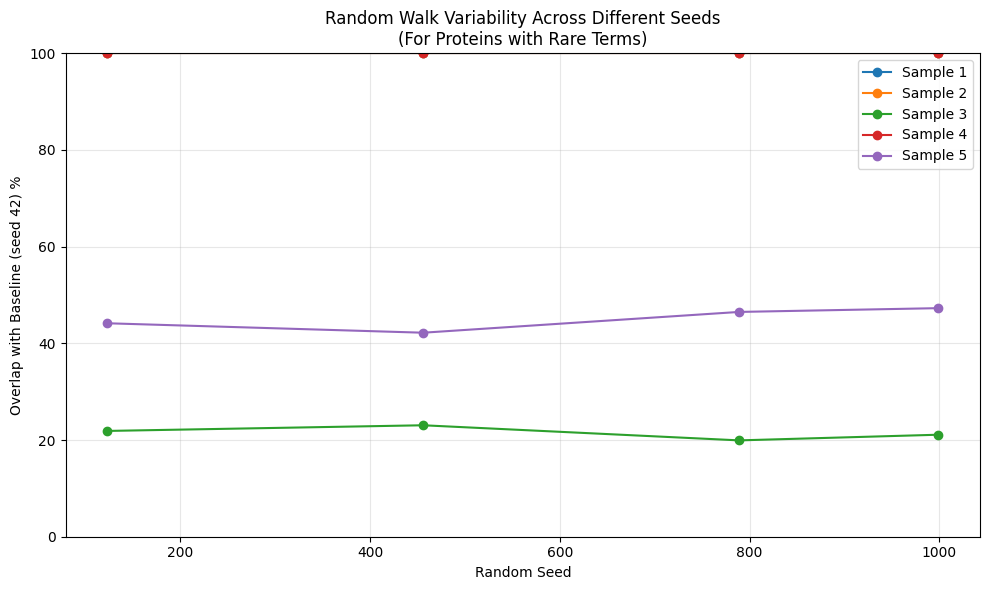


Average overlap across all samples: 73.30%
Std deviation: 33.55%
Min overlap: 19.92%
Max overlap: 100.00%


In [15]:
# Visualize the variability across all test samples
import matplotlib.pyplot as plt

# Calculate pairwise overlaps for each sample
overlap_data = []

for result in results:
    sample_overlaps = []
    baseline = set(result[f'seed_{test_seeds[0]}'])
    
    for seed in test_seeds[1:]:
        current = set(result[f'seed_{seed}'])
        overlap_pct = len(baseline & current) / 256 * 100
        sample_overlaps.append(overlap_pct)
    
    overlap_data.append(sample_overlaps)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, overlaps in enumerate(overlap_data):
    ax.plot(test_seeds[1:], overlaps, marker='o', label=f'Sample {i+1}')

ax.set_xlabel('Random Seed')
ax.set_ylabel('Overlap with Baseline (seed 42) %')
ax.set_title('Random Walk Variability Across Different Seeds\n(For Proteins with Rare Terms)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

print(f"\nAverage overlap across all samples: {np.mean(overlap_data):.2f}%")
print(f"Std deviation: {np.std(overlap_data):.2f}%")
print(f"Min overlap: {np.min(overlap_data):.2f}%")
print(f"Max overlap: {np.max(overlap_data):.2f}%")

In [5]:
seq_2_terms = pd.read_parquet(data_paths['knn_terms_df'], engine='fastparquet')
train_terms = pd.read_csv(data_paths['train_terms_df'], sep='\t')
seq_2_terms.shape

(82201, 3)

### Split

In [6]:
train_terms_grouped = train_terms.groupby('EntryID')['term'].apply(set).reset_index()
train_terms_grouped.head()

,EntryID,term
0,A0A023FBW4,{GO:0019958}
1,A0A023FBW7,{GO:0019957}
2,A0A023FDY8,{GO:0019957}
3,A0A023FF81,{GO:0019958}
4,A0A023FFB5,{GO:0019957}


In [7]:
# get label frequency 
label_frequency = train_terms['term'].value_counts().to_dict()

#get number of labels for each instance
train_terms_grouped['len']  = train_terms_grouped['term'].apply(len)
train_terms_grouped

,EntryID,term,len
0,A0A023FBW4,{GO:0019958},1
1,A0A023FBW7,{GO:0019957},1
2,A0A023FDY8,{GO:0019957},1
3,A0A023FF81,{GO:0019958},1
4,A0A023FFB5,{GO:0019957},1
...,...,...,...
82399,X2JI34,"{GO:0051762, GO:0106223}",2
82400,X4Y2L4,"{GO:0030214, GO:0033906}",2
82401,X5JA13,"{GO:0009506, GO:0070062, GO:0009536, GO:000588...",8
82402,X5JB51,"{GO:0009506, GO:0070062, GO:0005886, GO:000014...",8


In [54]:
#create mask for rare labels
rare_label_threshold = 10
rare_labels = {term for term, freq in label_frequency.items() if freq <= rare_label_threshold}

rare_labels_mask = train_terms_grouped['term'].apply(lambda terms: any(term in rare_labels for term in terms))
rare_labels_mask.sum()

len_threshold = 10
len_mask = train_terms_grouped['len'] <= len_threshold
len_mask.sum()


combined_mask = rare_labels_mask & len_mask
print(f"Instance with rare labels: {rare_labels_mask.sum()}, Instances with <= {len_threshold} total labels: {len_mask.sum()}")
print(f"Instances with rare labels and <= {len_threshold} total labels: {combined_mask.sum()} = {combined_mask.sum() / len(train_terms_grouped) * 100:.2f}%")

Instance with rare labels: 31786, Instances with <= 10 total labels: 68811
Instances with rare labels and <= 10 total labels: 21098 = 25.60%


In [17]:
split_segments = { 
    'label_freq' : [5, 10, 20],
    'num_label'  : [5, 10, 20],
    'factor'     : [8, 4, 2]
}
split_segments_df = pd.DataFrame(split_segments)
split_segments_df

,label_freq,num_label,factor
0,5,5,8
1,10,10,4
2,20,20,2


In [ ]:
for i in split_segments_df.index:
    print(row)

0
1


In [ ]:
split_segments_df.iloc[0]split_segments_df.iloc[0]['label_freq']

np.int64(10)

In [ ]:
split_segments_df.index

AttributeError: 'RangeIndex' object has no attribute 'reverse'

In [ ]:
#create mask for rare labels

train_terms_grouped['sampling_factor'] = 1

for i in range(len(split_segments_df) -1, -1, -1 ):

    row = split_segments_df.iloc[i]
    rare_label_threshold = row['label_freq']
    len_threshold = row['num_label']

    rare_labels = {term for term, freq in label_frequency.items() if freq <= rare_label_threshold}

    rare_labels_mask = train_terms_grouped['term'].apply(lambda terms: any(term in rare_labels for term in terms))
    rare_labels_mask.sum()

    
    len_mask = train_terms_grouped['len'] <= len_threshold
    len_mask.sum()

    
    combined_mask = rare_labels_mask & len_mask
    train_terms_grouped['sampling_factor'] = np.where(combined_mask, row['factor'], train_terms_grouped['sampling_factor'])
    # print(f"Instance with rare labels  < {rare_label_threshold}: {rare_labels_mask.sum()}, Instances with <= {len_threshold} total labels: {len_mask.sum()}")
    print(f"Instances with rare labels < {rare_label_threshold} and <= {len_threshold} total labels: {combined_mask.sum()} = {combined_mask.sum() / len(train_terms_grouped) * 100:.2f}% \t factor { row['factor']}")

# sampling_dict =dict(zip(train_terms_grouped['EntryID'], train_terms_grouped['sampling_factor']))

Instances with rare labels < 20 and <= 20 total labels: 39193 = 47.56% 	 factor 2
Instances with rare labels < 10 and <= 10 total labels: 21098 = 25.60% 	 factor 4
Instances with rare labels < 5 and <= 5 total labels: 6394 = 7.76% 	 factor 8


In [41]:
train_terms_grouped['sampling_factor'].sum()

np.int64(189369)

In [39]:
sampling_dict =dict(zip(train_terms_grouped['EntryID'], train_terms_grouped['sampling_factor']))

In [44]:
#save sampling dict
import pickle
with open('./sampling_dict.pkl', 'wb') as f:
    pickle.dump(sampling_dict, f)


In [33]:
train_terms_grouped['sampling_factor'].value_counts(normalize=True) 

sampling_factor
1    0.524380
2    0.219589
4    0.178438
8    0.077593
Name: proportion, dtype: float64

rare    len                 factor                    addiction     max term addition
10      10      =  25.6%    x4     max=(4 * 10 = 30)  102.4%        +768%
20      20      =  21.96%   X2     max=(2 * 20 = 20)  26.96%        +439% 
Total                                                 129%          +1207% 

Not all are in 

### Coverage

In [16]:
def check_coverage(row):
    """Check what percentage of train_terms_all are in terms_predicted"""
    # Check if train_terms_all is None or empty list
    true_key  = 'terms_true'
    if row[true_key] is None or (isinstance(row[true_key], list) and len(row[true_key]) == 0):
        return None
    
    train_set = set(row[true_key])
    pred_set = set(row['terms_predicted'])
    
    # Find terms in train_terms_all that are in terms_predicted
    covered_terms = train_set.intersection(pred_set)
    
    # Calculate coverage percentage
    coverage = len(covered_terms) / len(train_set) * 100 if len(train_set) > 0 else 0
    
    return {
        'total_train_terms': len(train_set),
        'covered_terms': len(covered_terms),
        'missing_terms': len(train_set) - len(covered_terms),
        'coverage_pct': coverage,
        'missing_term_list': list(train_set - covered_terms)
    }

In [12]:
data_paths = {
    'knn_terms_df':         '/mnt/d/ML/Kaggle/CAFA6-new/uniprot/diamond_knn_predictions.parquet',
    'train_terms_df':       '/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_terms.tsv',
    'go_obo_path':          '/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/go-basic.obo',
    'features_embeds_path': '/mnt/d/ML/Kaggle/CAFA6-new/Dataset/esm_t33_650M/train_embeds.npy',
    'features_ids_path':    '/mnt/d/ML/Kaggle/CAFA6-new/Dataset/esm_t33_650M/train_ids.npy',
    'go_embeds_paths':      '/mnt/d/ML/Kaggle/CAFA6-new/uniprot/go_embeddings.pkl'
}

seq_2_terms = pd.read_parquet(data_paths['knn_terms_df'], engine='fastparquet')

seq_2_terms['len'] = seq_2_terms['terms_predicted'].apply(len)
seq_2_terms.head()

,qseqid,terms_predicted,terms_true,len
0,A0A023FBW4,"[GO:0019958, GO:0005576]",[GO:0019958],2
1,A0A023FBW7,"[GO:0019957, GO:0005576]",[GO:0019957],2
2,A0A023FDY8,"[GO:0019957, GO:0005576]",[GO:0019957],2
3,A0A023FF81,"[GO:0019958, GO:0005576]",[GO:0019958],2
4,A0A023FFB5,[],[GO:0019957],0


In [24]:
coverage_results= seq_2_terms.apply(check_coverage, axis=1)
coverage_df = pd.DataFrame(coverage_results.tolist())

# seq_2_terms['coverage'].sort_values(ascending=False)

Average coverage: 89.30%
Median coverage: 100.00%
Instances with 100% coverage: 68712 / 82201
Instances with 0% coverage: 6836 / 82201


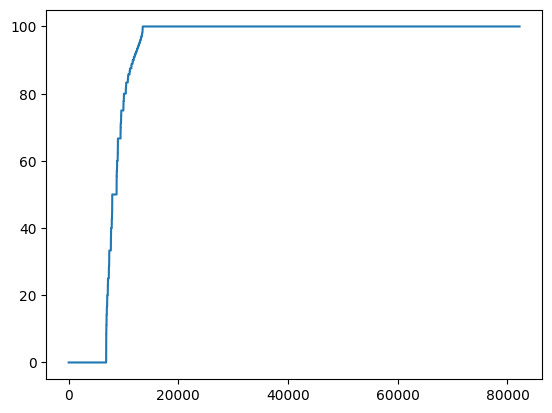

In [31]:
import matplotlib.pyplot as plt

print(f"Average coverage: {coverage_df['coverage_pct'].mean():.2f}%")
print(f"Median coverage: {coverage_df['coverage_pct'].median():.2f}%")
print(f"Instances with 100% coverage: {(coverage_df['coverage_pct'] == 100).sum()} / {len(coverage_df)}")
print(f"Instances with 0% coverage: {(coverage_df['coverage_pct'] == 0).sum()} / {len(coverage_df)}")
plt.plot(coverage_df['coverage_pct'].sort_values().values)